### Pengaruh Adaptive Learning Rate dan Data Preprocessing Terhadap Perbandingan Hasil Akurasi Model Neural Network Pediksi Harga Berlian

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error


warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

### Preproses Data

In [2]:
# import data
data = pd.read_csv("Diamonds Prices2022.csv")
data.drop("Unnamed: 0", axis = 'columns', inplace = True)

In [3]:
data

carat        cut color clarity  depth  table  price     x     y     z
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53938   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64
53940   0.71    Premium     E     SI1   60.5   55.0   2756  5.79  5.74  3.49
53941   0.71    Premium     F     SI1   59.8   62.0   2756  5.74  5.73  3.43
53942   0.70  Very Good     E     VS2   60.5   59.0   2757  5.71  5.76  3.47

[53943 rows x 10 columns]

In [4]:
data.describe()

carat         depth         table         price             x  \
count  53943.000000  53943.000000  53943.000000  53943.000000  53943.000000   
mean       0.797935     61.749322     57.457251   3932.734294      5.731158   
std        0.473999      1.432626      2.234549   3989.338447      1.121730   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.000000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53943.000000  53943.000000  
mean       5.734526      3.538730  
std        1.142103      0.705679  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.900000     31.800000

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
# cek data duplikat
data.duplicated().sum()

149

In [7]:
# hapus semua duplikat, karena jumlah sedikit hapus saja
data.drop_duplicates(ignore_index= True, inplace = True)

In [8]:
data.duplicated().sum()

0

In [9]:
# cek data hilang
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [10]:
# cek nilai pada tiap data kategorikal
for nama_kolom in data.columns:
    if data[nama_kolom].dtype == "object":
        print(f"kolom : {nama_kolom} punya data unik \n{data[nama_kolom].unique()} \n")

kolom : cut punya data unik 
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair'] 

kolom : color punya data unik 
['E' 'I' 'J' 'H' 'F' 'G' 'D'] 

kolom : clarity punya data unik 
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF'] 



In [11]:
# memisahkan nama kolom untuk data kategorikal dan non-kategorikal
kolom_num = []
kolom_str = []

for data_kolom in data.columns:
    if data[data_kolom].dtype == "object":
        kolom_str.append(data_kolom)
    else:
        kolom_num.append(data_kolom)

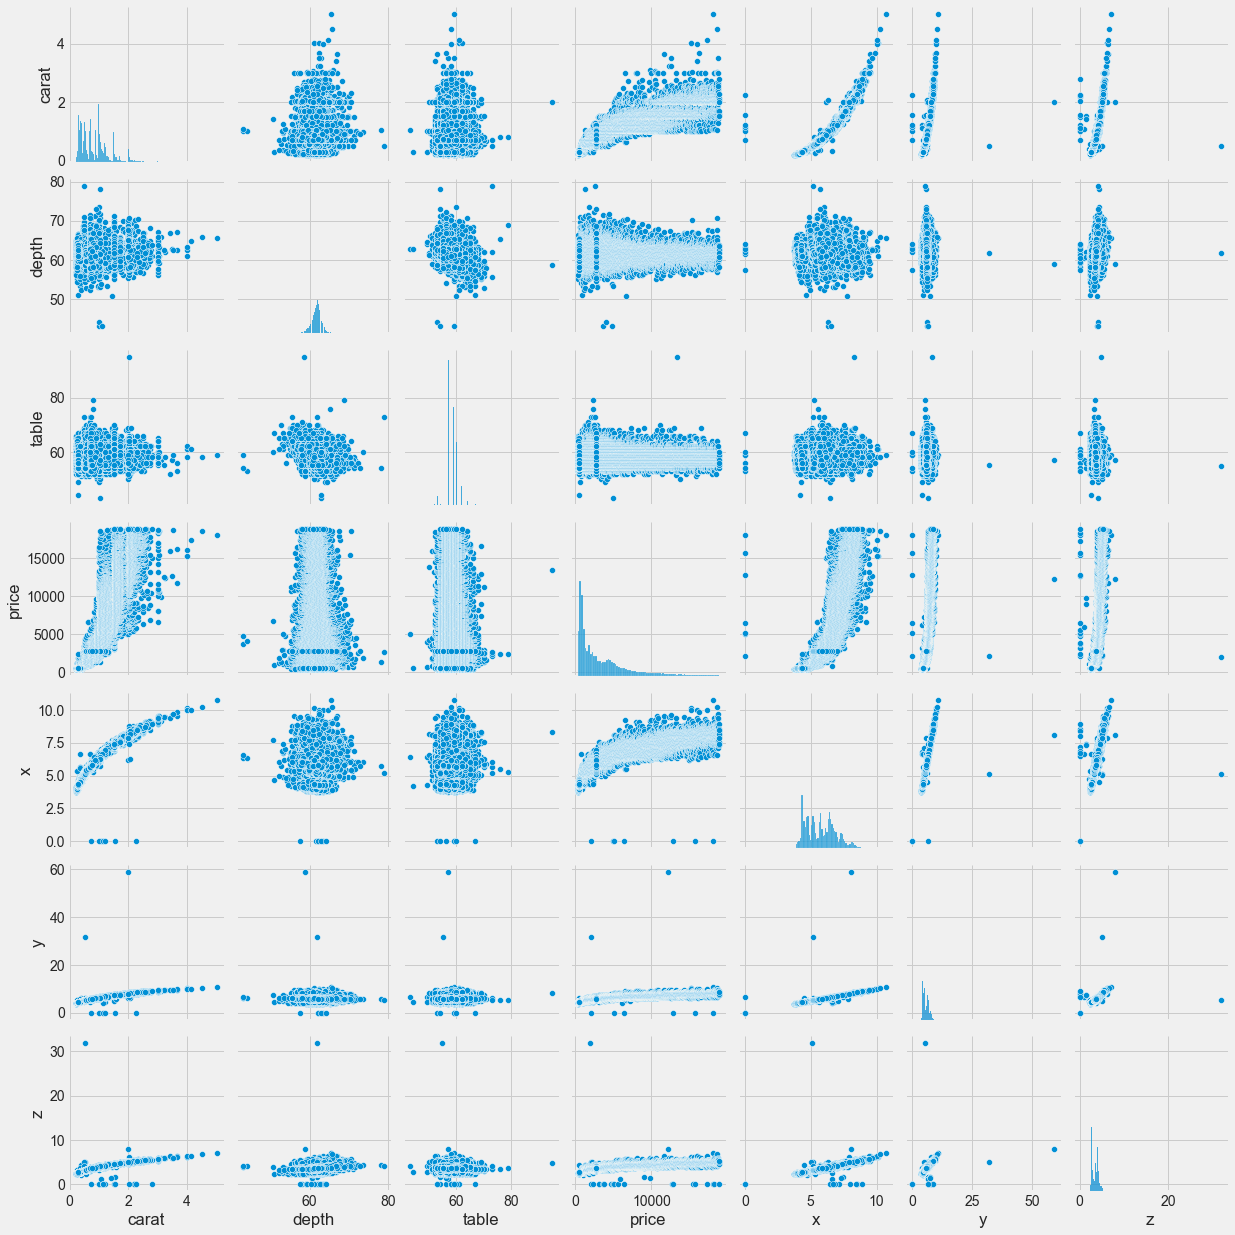

In [12]:
# lihat hubungan scatter plot pada tiap kolom dengan kolom lain
sns.pairplot(data)

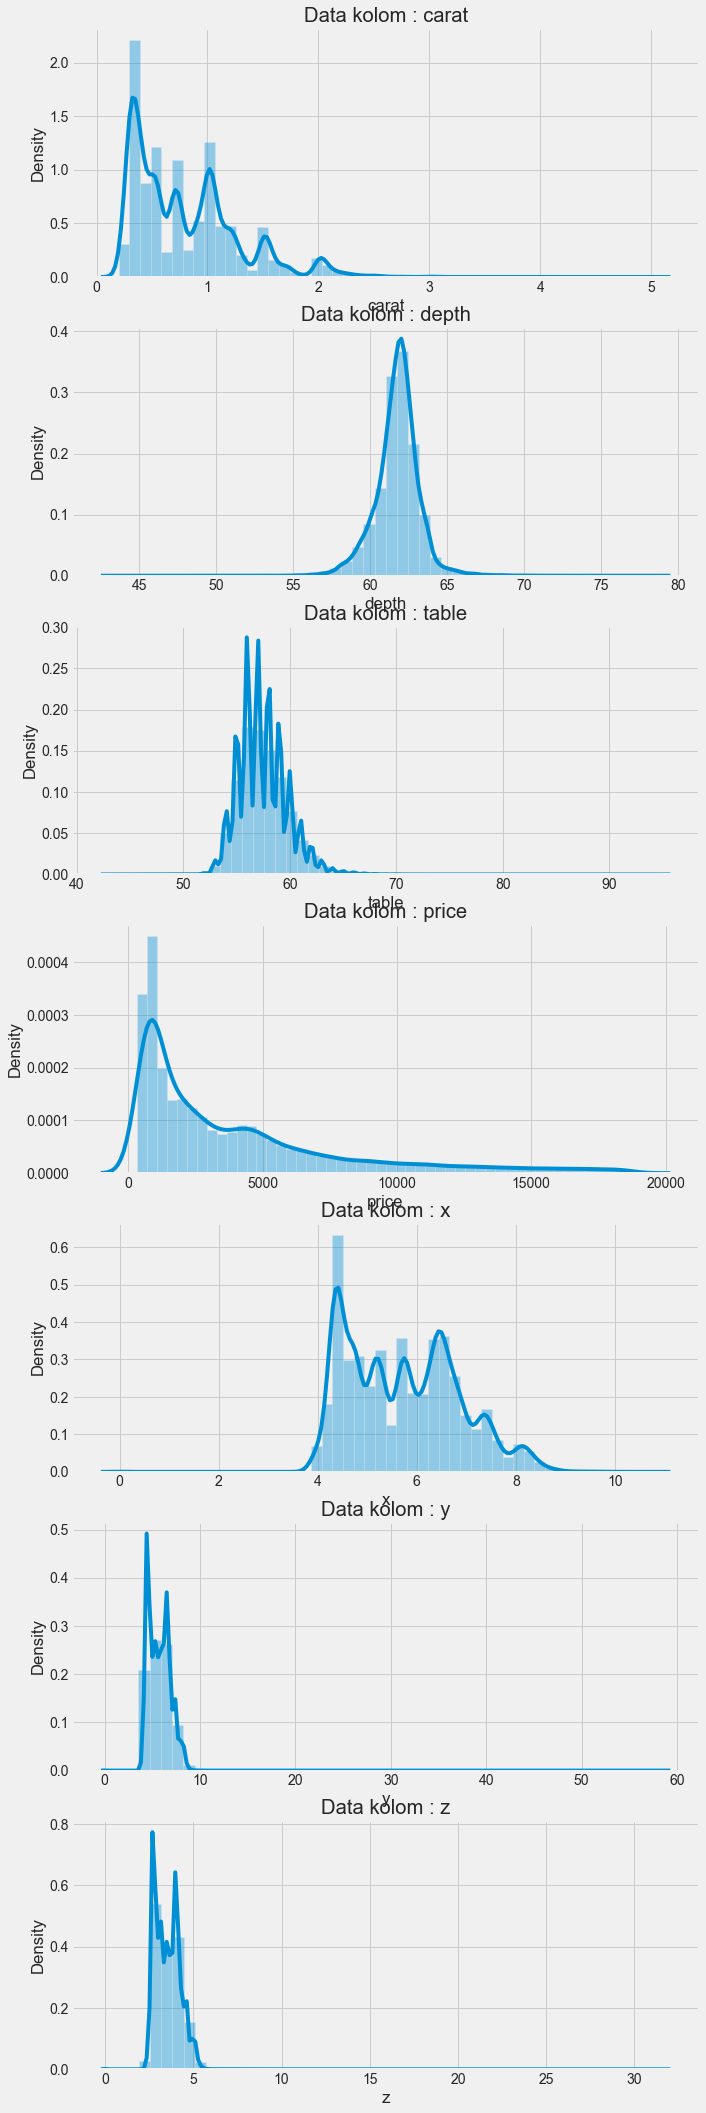

In [13]:
# persebaran data numerikal
fig, axes = plt.subplots(nrows=7, ncols=1, figsize = (10,35))


for i, ax in enumerate(fig.axes):
    sns.distplot(data[kolom_num[i]], ax = ax)
    ax.set_title(f"Data kolom : {kolom_num[i]}")

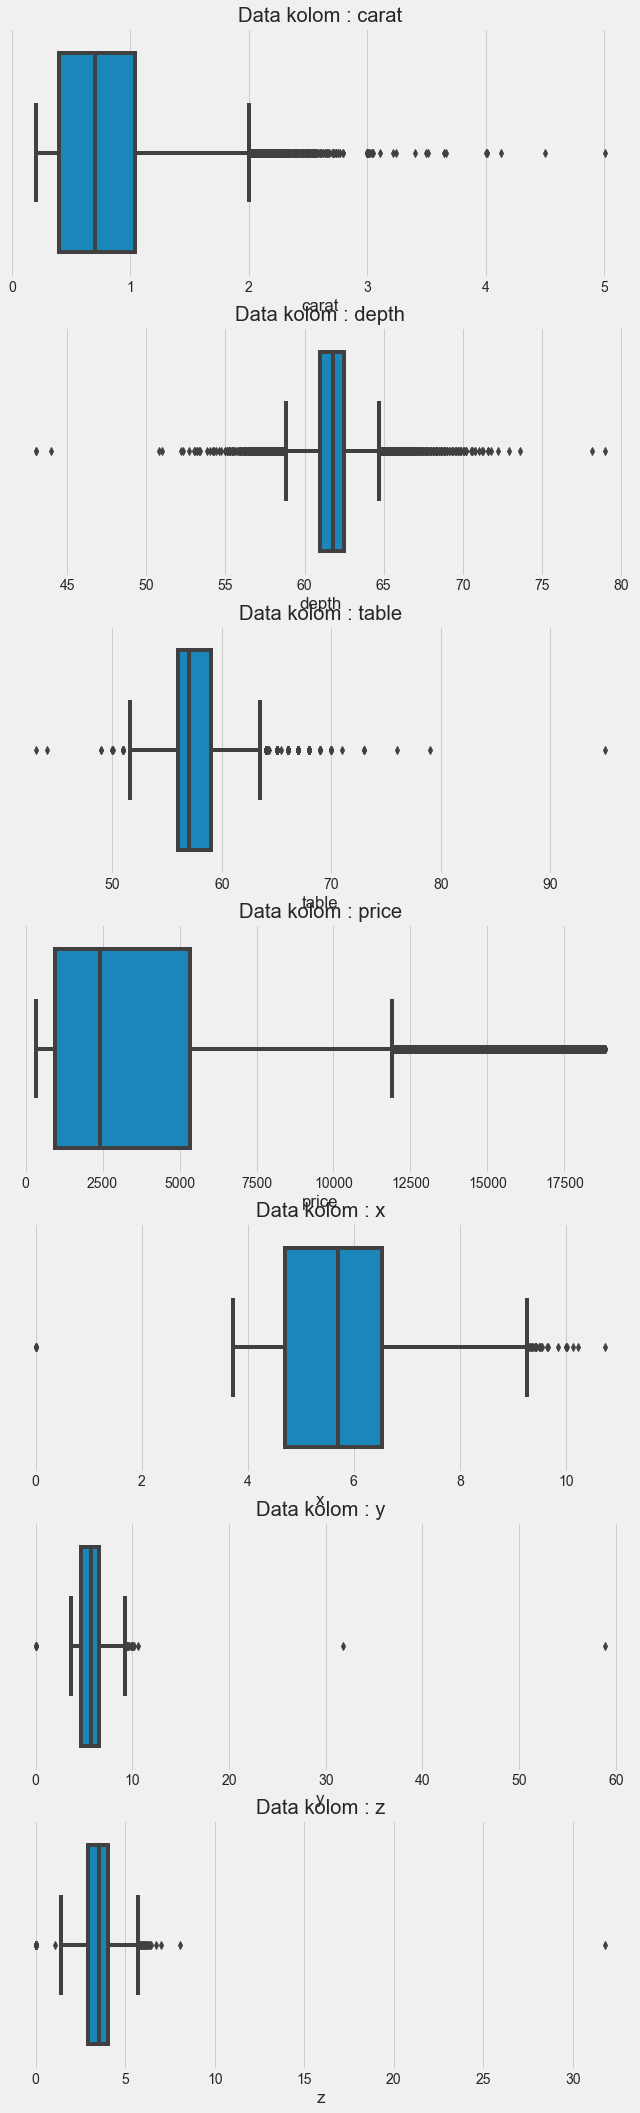

In [14]:
# persebaran data numerikal dalam boxplot
fig, axes = plt.subplots(nrows=7, ncols=1, figsize = (10,35))


for i, ax in enumerate(fig.axes):
    sns.boxplot(data[kolom_num[i]], ax = ax)
    ax.set_title(f"Data kolom : {kolom_num[i]}")

In [15]:
# hilangkan outliers dengan menghilangkan satu persen percentile teratas dan terbawah pada
# kolo numerikal
data_clean1 = data.loc[data.carat < data.carat.quantile(0.99)]
data_clean2 = data_clean1.loc[data_clean1.table < data_clean1.table.quantile(0.99)]
data_clean3 = data_clean2.loc[data_clean2.x < data_clean2.x.quantile(0.99)]
data_clean4 = data_clean3.loc[data_clean3.price < data_clean3.price.quantile(0.99)]
data_clean5 = data_clean4.loc[data_clean4.y < data_clean4.y.quantile(0.99)]
data_clean6 = data_clean5.loc[data_clean5.depth < data_clean5.depth.quantile(0.99)]
data_clean7 = data_clean6.loc[data_clean6.depth > data_clean6.depth.quantile(0.01)]
data_clean8 = data_clean7.loc[data_clean7.z < data_clean7.z.quantile(0.99)]
data_clean9 = data_clean8.loc[data_clean8.table > data_clean8.table.quantile(0.01)]
data_clean10 = data_clean9.loc[data_clean9.x > data_clean9.x.quantile(0.01)]
data_clean11 = data_clean10.loc[data_clean10.y > data_clean10.y.quantile(0.01)]
data_clean12 = data_clean11.loc[data_clean11.z > data_clean11.z.quantile(0.01)]
data_no_outliers = data_clean12.copy()
data_no_outliers

carat        cut color clarity  depth  table  price     x     y     z
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
10      0.30       Good     J     SI1   64.0   55.0    339  4.25  4.28  2.73
13      0.31      Ideal     J     SI2   62.2   54.0    344  4.35  4.37  2.71
15      0.32    Premium     E      I1   60.9   58.0    345  4.38  4.42  2.68
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53789   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
53790   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
53791   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
53792   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53793   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[47219 rows x 10 columns]

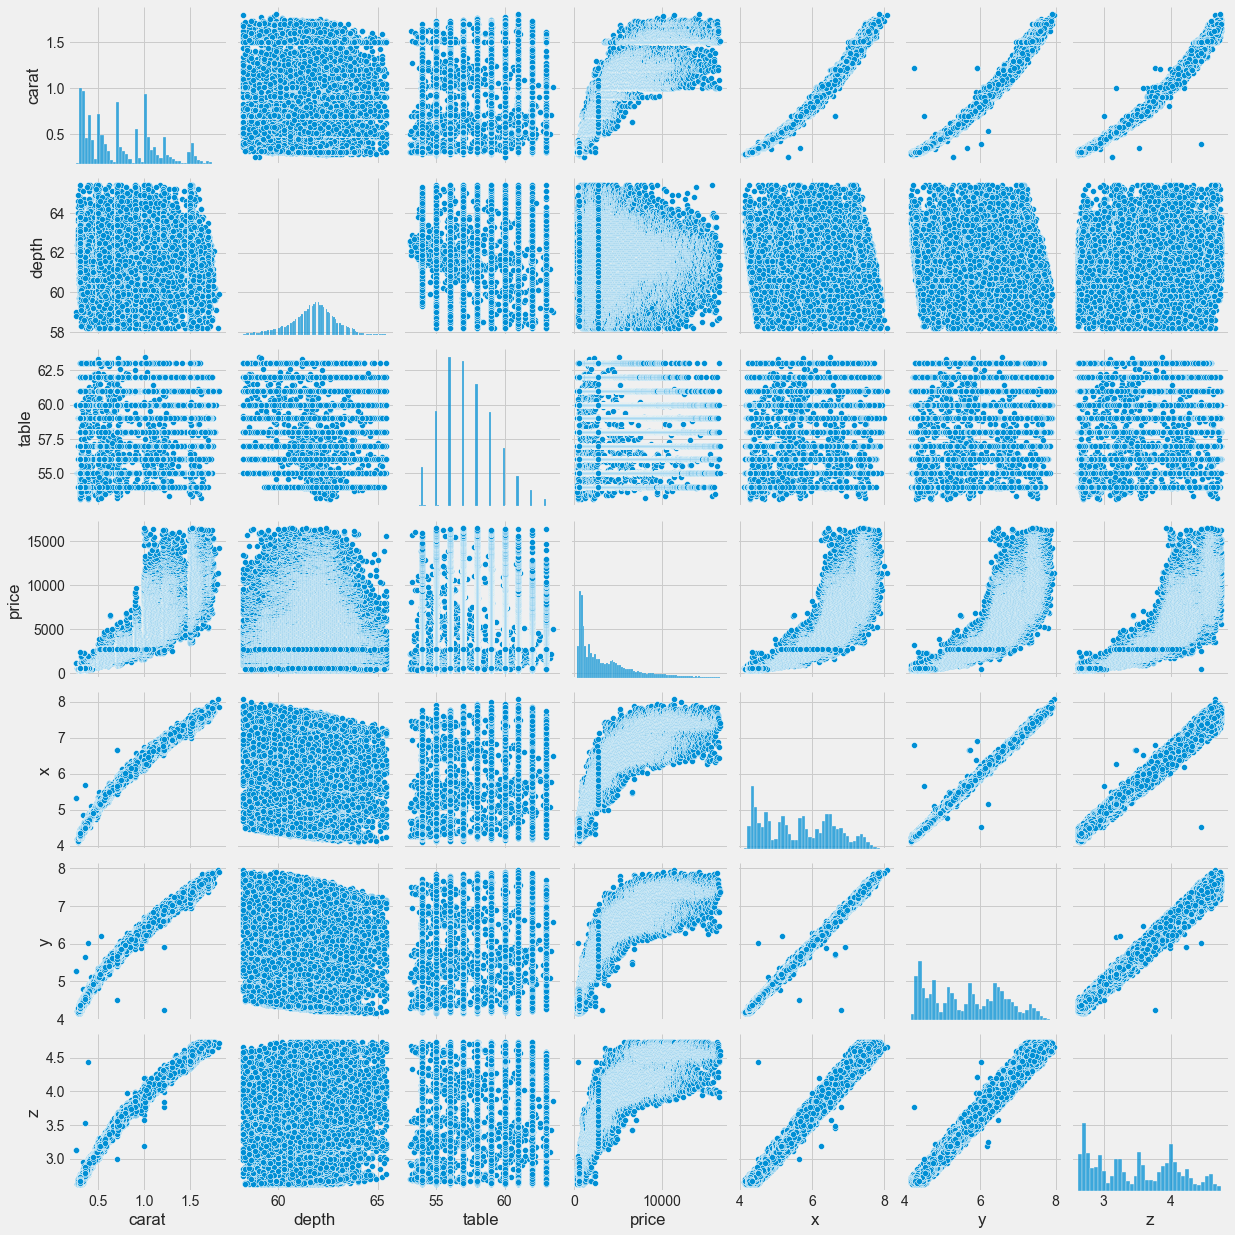

In [16]:
# hasil hubungan tiap kolom setelah menghilangkan outliers
sns.pairplot(data_no_outliers)

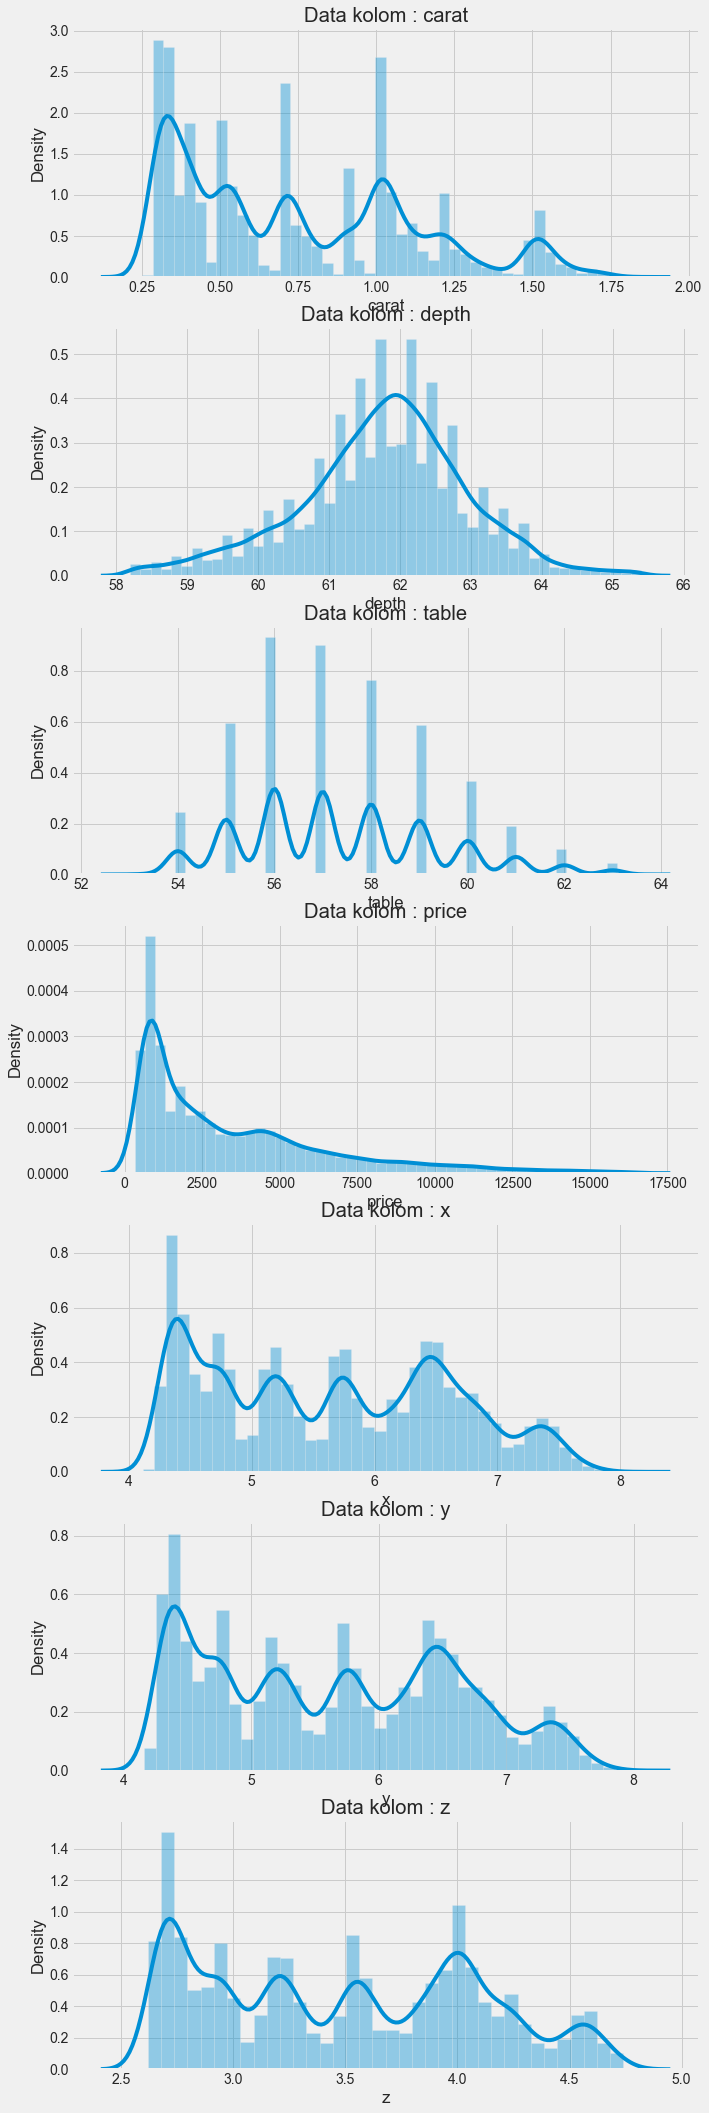

In [17]:
# persebaran data numerial setelah penghilangan outliers
fig, axes = plt.subplots(nrows=7, ncols=1, figsize = (10,35))

for i, ax in enumerate(fig.axes):
    sns.distplot(data_no_outliers[kolom_num[i]], ax = ax)
    ax.set_title(f"Data kolom : {kolom_num[i]}")

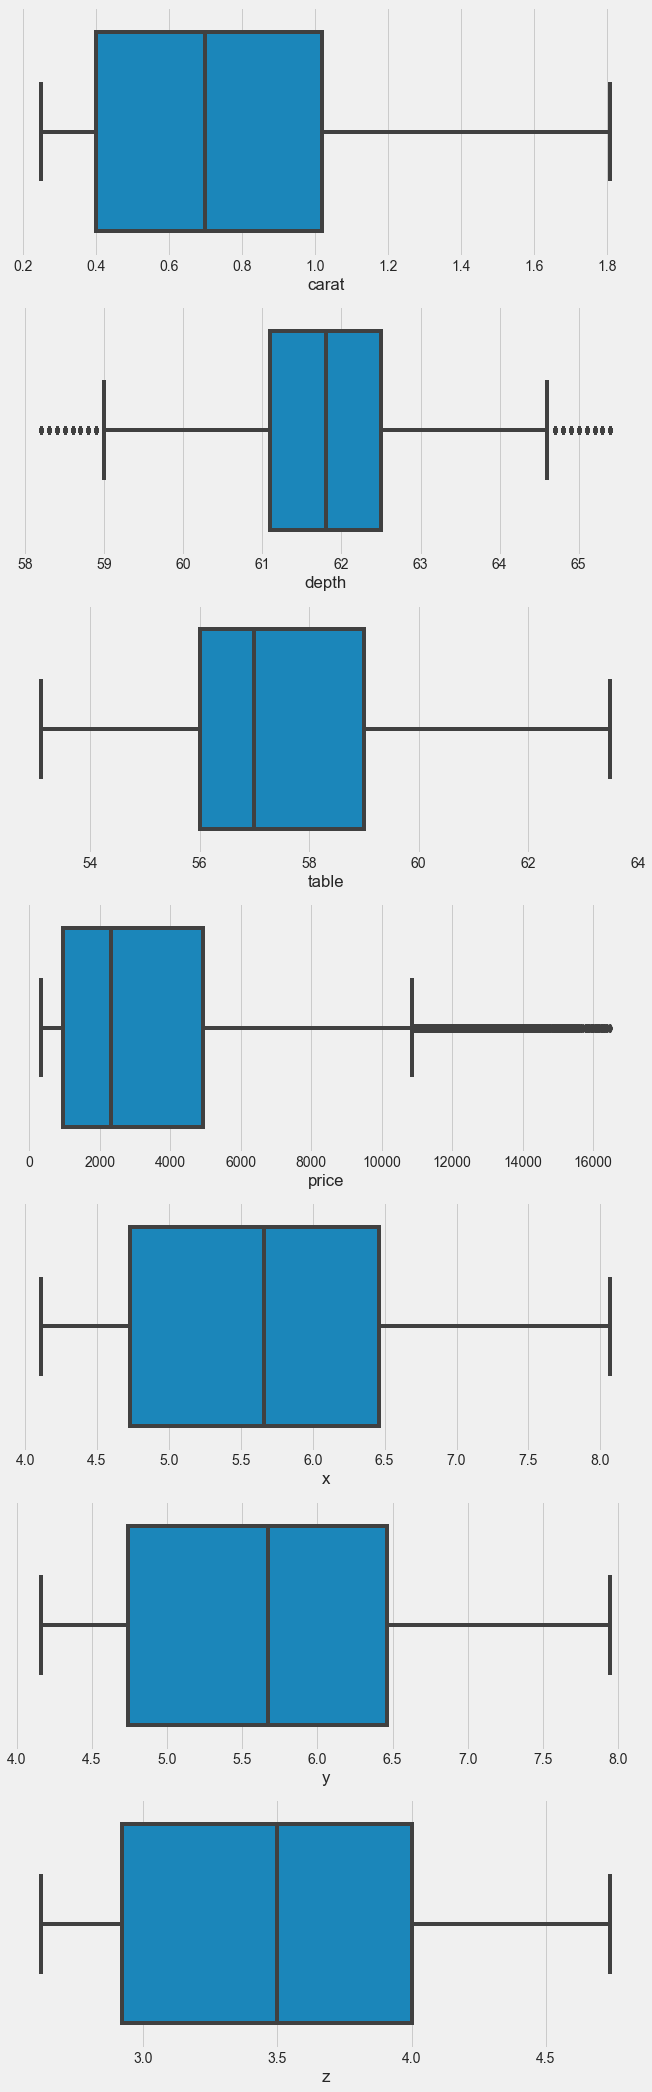

In [18]:
# boxplot data numerikal setelah menghilangkan outliers
fig, axes = plt.subplots(nrows=7, ncols=1, figsize = (10,35))

for i, ax in enumerate(fig.axes):
    sns.boxplot(data_no_outliers[kolom_num[i]], ax = ax)

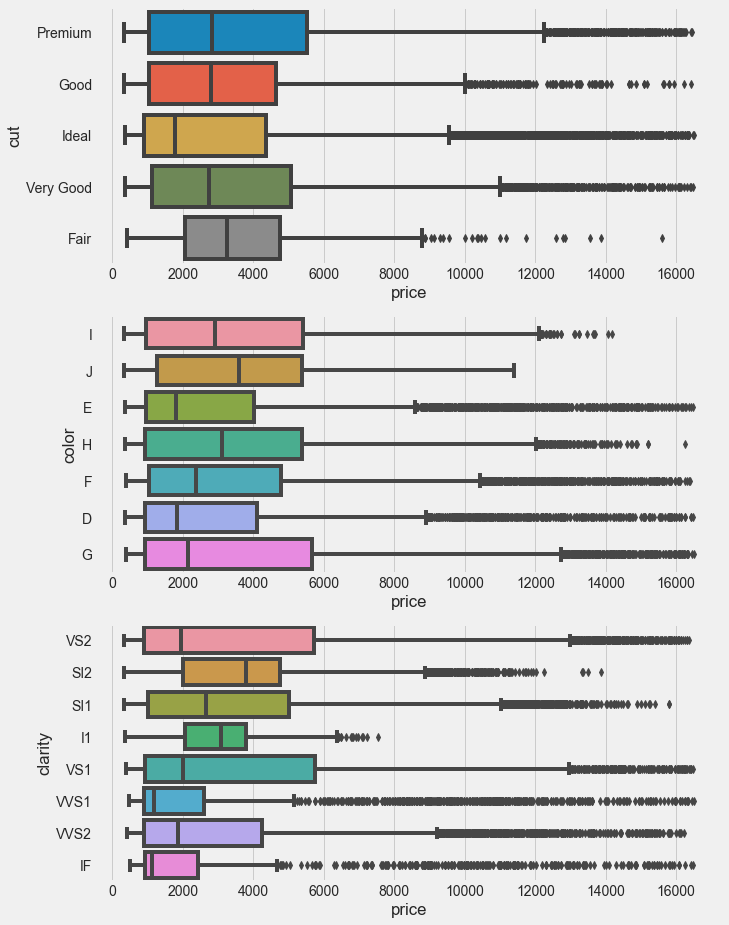

In [19]:
# boxplot, persebaran data kategorikal tiap kategori terhadap harga dari berlian
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

for i, ax in enumerate(fig.axes):
    sns.boxplot(data_no_outliers['price'], y = data_no_outliers[kolom_str[i]]
                , ax = ax)

<AxesSubplot:>

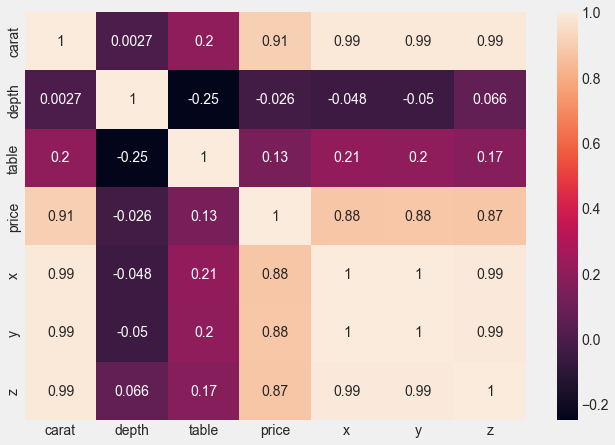

In [20]:
# korelasi tiap kolom numerikal setelah penghilangan outliers
plt.figure(figsize = (10, 7))
sns.heatmap(data_no_outliers.corr(), annot= True)

In [21]:
data_no_outliers

carat        cut color clarity  depth  table  price     x     y     z
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
10      0.30       Good     J     SI1   64.0   55.0    339  4.25  4.28  2.73
13      0.31      Ideal     J     SI2   62.2   54.0    344  4.35  4.37  2.71
15      0.32    Premium     E      I1   60.9   58.0    345  4.38  4.42  2.68
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53789   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
53790   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
53791   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
53792   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53793   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[47219 rows x 10 columns]

In [22]:
# dengan melihat x,y,z sangat erat hubungannya
# maka dari x,y,z dikalikan untuk hasilkan nilai berupa volume

data_no_outliers['volume'] = (data_no_outliers.x.values * data_no_outliers.y.values * data_no_outliers.z.values)
data_no_outliers['volume'] = data_no_outliers.volume.round(2)
data_no_outliers

carat        cut color clarity  depth  table  price     x     y     z  \
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   
10      0.30       Good     J     SI1   64.0   55.0    339  4.25  4.28  2.73   
13      0.31      Ideal     J     SI2   62.2   54.0    344  4.35  4.37  2.71   
15      0.32    Premium     E      I1   60.9   58.0    345  4.38  4.42  2.68   
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
53789   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50   
53790   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61   
53791   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56   
53792   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74   
53793   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64   

       volume  
3       46.72  
4       51.92  
10      49.66  
13      51.52  
15      51.88  
...       ...  
53789  115.92  
53790  118.11  
53791  114.45  
53792  140.77  
53793  124.57  

[47219 rows x 11 columns]

In [23]:
# buat dataset ada volume tanpa x,y,z
# hapus kolom x,y,z dab gunakan kolom volume

data_no_outliers_volume = data_no_outliers.drop(['x','y','z'], axis = 'columns').copy()
data_no_outliers_volume

carat        cut color clarity  depth  table  price  volume
3       0.29    Premium     I     VS2   62.4   58.0    334   46.72
4       0.31       Good     J     SI2   63.3   58.0    335   51.92
10      0.30       Good     J     SI1   64.0   55.0    339   49.66
13      0.31      Ideal     J     SI2   62.2   54.0    344   51.52
15      0.32    Premium     E      I1   60.9   58.0    345   51.88
...      ...        ...   ...     ...    ...    ...    ...     ...
53789   0.72      Ideal     D     SI1   60.8   57.0   2757  115.92
53790   0.72       Good     D     SI1   63.1   55.0   2757  118.11
53791   0.70  Very Good     D     SI1   62.8   60.0   2757  114.45
53792   0.86    Premium     H     SI2   61.0   58.0   2757  140.77
53793   0.75      Ideal     D     SI2   62.2   55.0   2757  124.57

[47219 rows x 8 columns]

In [148]:
data_no_outliers_volume.iloc[37923]

carat       0.59
cut        Ideal
color          H
clarity      SI1
depth       61.1
table       57.0
price       1445
volume     96.23
Name: 43696, dtype: object

In [24]:
# data tanpa outliers akhir setelah menggunakan kolom volume
data_no_outliers_volume.describe()

carat         depth         table         price        volume
count  47219.000000  47219.000000  47219.000000  47219.000000  47219.000000
mean       0.743085     61.767236     57.345494   3454.215570    121.072143
std        0.377077      1.186779      1.989460   3158.589406     60.951740
min        0.250000     58.200000     53.100000    334.000000     45.420000
25%        0.400000     61.100000     56.000000    967.000000     65.690000
50%        0.700000     61.800000     57.000000   2319.000000    113.410000
75%        1.020000     62.500000     59.000000   4922.000000    166.095000
max        1.810000     65.400000     63.500000  16492.000000    298.970000

##### Transform Data

In [25]:
# data DENGAN outliers
data_with_outliers = data.copy()
data_with_outliers['volume'] = (data.x.values * data.y.values * data.z.values)
data_with_outliers.drop(['x','z','y'], axis = 'columns', inplace = True)
data_with_outliers

carat        cut color clarity  depth  table  price      volume
0       0.23      Ideal     E     SI2   61.5   55.0    326   38.202030
1       0.21    Premium     E     SI1   59.8   61.0    326   34.505856
2       0.23       Good     E     VS1   56.9   65.0    327   38.076885
3       0.29    Premium     I     VS2   62.4   58.0    334   46.724580
4       0.31       Good     J     SI2   63.3   58.0    335   51.917250
...      ...        ...   ...     ...    ...    ...    ...         ...
53789   0.72      Ideal     D     SI1   60.8   57.0   2757  115.920000
53790   0.72       Good     D     SI1   63.1   55.0   2757  118.110175
53791   0.70  Very Good     D     SI1   62.8   60.0   2757  114.449728
53792   0.86    Premium     H     SI2   61.0   58.0   2757  140.766120
53793   0.75      Ideal     D     SI2   62.2   55.0   2757  124.568444

[53794 rows x 8 columns]

In [26]:
# data dengan outliers
data_x_outliers = data_with_outliers.drop('price', axis = 'columns')
data_y_outliers = data_with_outliers['price']

In [27]:
# data tanpa outliers
data_x = data_no_outliers_volume.drop("price", axis = "columns")
data_y = data_no_outliers_volume['price']

In [28]:
# fungsi untuk transform kolom dalam sebuah Dataframe

def column_transformer_df(dataframe, scaler_column = [], 
                          oneHot_column = [], ordinalEnc_column = [],
                          minmax_column = [], normalize_column = []):
    columm_transformer = make_column_transformer(

        (StandardScaler(), scaler_column),
        (MinMaxScaler(), minmax_column),
        (OneHotEncoder(), oneHot_column),
        (OrdinalEncoder(), ordinalEnc_column),
        (Normalizer(), normalize_column),
        remainder= "passthrough",
        n_jobs= -1

    )
    
    return pd.DataFrame(columm_transformer.fit_transform(dataframe))

In [29]:
scaler = ['carat', 'depth', 'table', 'volume']
oneHot = []
OrdinalEnc = ['cut', 'color', 'clarity']

# preproses data tanpa outliers
data_x_scaling = column_transformer_df(data_x, minmax_column= scaler, ordinalEnc_column= OrdinalEnc)

# preproses data dengan outliers
data_x_outliers_scaling = column_transformer_df(data_x_outliers, #minmax_column= scaler,
                                                ordinalEnc_column= OrdinalEnc)

In [30]:
# hasil scaling data dengan outliers

data_x_outliers_scaling

0    1    2     3     4     5           6
0      2.0  1.0  3.0  0.23  61.5  55.0   38.202030
1      3.0  1.0  2.0  0.21  59.8  61.0   34.505856
2      1.0  1.0  4.0  0.23  56.9  65.0   38.076885
3      3.0  5.0  5.0  0.29  62.4  58.0   46.724580
4      1.0  6.0  3.0  0.31  63.3  58.0   51.917250
...    ...  ...  ...   ...   ...   ...         ...
53789  2.0  0.0  2.0  0.72  60.8  57.0  115.920000
53790  1.0  0.0  2.0  0.72  63.1  55.0  118.110175
53791  4.0  0.0  2.0  0.70  62.8  60.0  114.449728
53792  3.0  4.0  3.0  0.86  61.0  58.0  140.766120
53793  2.0  0.0  3.0  0.75  62.2  55.0  124.568444

[53794 rows x 7 columns]

In [31]:
# hasil scaling data TANPA outliers

data_x_scaling

0         1         2         3    4    5    6
0      0.025641  0.583333  0.471154  0.005127  3.0  5.0  5.0
1      0.038462  0.708333  0.471154  0.025636  1.0  6.0  3.0
2      0.032051  0.805556  0.182692  0.016723  1.0  6.0  2.0
3      0.038462  0.555556  0.086538  0.024058  2.0  6.0  3.0
4      0.044872  0.375000  0.471154  0.025478  3.0  1.0  0.0
...         ...       ...       ...       ...  ...  ...  ...
47214  0.301282  0.361111  0.375000  0.278052  2.0  0.0  2.0
47215  0.301282  0.680556  0.182692  0.286689  1.0  0.0  2.0
47216  0.288462  0.638889  0.663462  0.272254  4.0  0.0  2.0
47217  0.391026  0.388889  0.471154  0.376060  3.0  4.0  3.0
47218  0.320513  0.555556  0.182692  0.312167  2.0  0.0  3.0

[47219 rows x 7 columns]

In [32]:
# split data

# split data scaling dengan outliers
x_train_outliers, x_test_outliers, y_train_outliers, y_test_outliers = train_test_split(data_x_outliers_scaling, data_y_outliers, shuffle = True,              random_state=42, test_size=0.2)

# split data scaling TANPA outliers
x_train, x_test, y_train, y_test = train_test_split(data_x_scaling, data_y, test_size= 0.2,
                                                    shuffle= True, random_state= 42)

In [33]:
# cek sudah sesuai atau belum dengan size yang diharapkan
len(x_train) / len(data_x_scaling)

0.799995764416866

In [34]:
len(x_train_outliers) / len(data_with_outliers)

0.7999962821132468

In [35]:
# kesalahan awal, BUAT DATA TEST UNTUK SEMUA MODEL GUNAKAN HASIL INI SAJA
x_train_test, x_test_test, y_train_test, y_test_test = train_test_split(data_x_outliers, data_y_outliers, test_size= 0.2,
                                                    shuffle= True, random_state= 42)

In [36]:
x_test_test

carat        cut color clarity  depth  table      volume
43520   0.71       Fair     J     VS2   64.9   54.0  112.704718
4264    0.90  Very Good     E     SI2   61.0   59.0  142.673952
47271   0.57      Ideal     G     VS1   62.1   56.0   93.221700
44300   0.51    Premium     E     VS2   62.5   60.0   82.387440
13943   1.19      Ideal     I     SI1   62.3   55.0  196.634240
...      ...        ...   ...     ...    ...    ...         ...
41659   0.52    Premium     G     SI1   62.6   58.0   83.721600
43406   0.52      Ideal     G     VS2   61.7   56.0   85.263915
35681   0.32      Ideal     F    VVS1   61.5   56.0   53.138736
25827   1.54    Premium     E     VS2   62.3   58.0  247.415722
39206   0.35    Premium     E    VVS1   63.0   59.0   55.894272

[10759 rows x 7 columns]

In [37]:
len(x_test_test) / len(data_x)

0.22785319468857876

### Buat, Train, Testing, Evaluate Model

### Buat model NN

In [38]:
# cari learning rate "terbaik" untuk digunakan sebagai base learning pada model utama
tf.random.set_seed(42)

model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error],
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['mae', 'mse'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-3 * 10**(epoch/20))
history_cari_lr = model.fit(x_train, y_train, epochs=100, callbacks=[lr_scheduler], verbose= 0)

Text(0, 0.5, 'MAE')

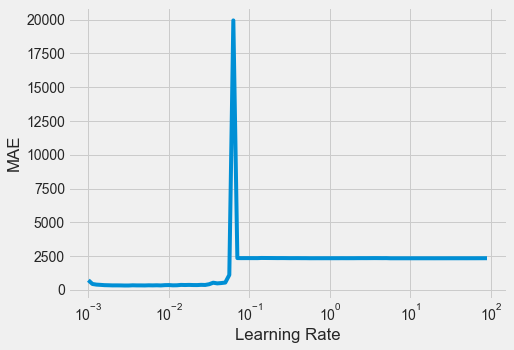

In [39]:
plt.figure(figsize = (7, 5))
plt.semilogx(history_cari_lr.history['lr'], history_cari_lr.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('MAE')

In [40]:
# hasil model ketika menghasilkan loss terendah pakai lr berapa
history_df = pd.DataFrame(history_cari_lr.history)
history_df.sort_values("loss", ascending= True).head()

loss         mae           mse        lr
9   320.554260  320.554260  295780.15625  0.002818
10  321.244476  321.244476  293224.03125  0.003162
14  324.902222  324.902222  300036.31250  0.005012
18  326.772552  326.772552  312114.03125  0.007943
8   328.099121  328.099121  311402.03125  0.002512

## Model dengan Adaptive Learning Rate

In [41]:
model_arsitektur = tf.keras.Sequential([
    
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(1)
    
])

#### Train Model data dengan Data Preprocessing

In [123]:
# menentukan layer dalam NN
# https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3

# design NN
# https://www.kdnuggets.com/2019/11/designing-neural-networks.html
tf.random.set_seed(42)

model1 = model_arsitektur

# compile model yang akan digunakan dan set learning rate berdasarkan lr yang sudah 
# ditemukan sebelumnya di atas dibulatkan ke satuan terdekat
model1.compile(loss = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error],
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['mae', 'mse'])


def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr
    if lr < 1e-5:
        return 1e-5
    else:
        return lr * tf.math.exp(-0.1)
        

# bahas ttg early_stopping
# https://stats.stackexchange.com/questions/231061/how-to-use-early-stopping-properly-for-training-deep-neural-network
lr_scheduler_riil = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)

In [124]:
# train model
history_real_df = model1.fit(x_train, y_train, validation_split=0.2, verbose=2, shuffle=True,  
                         epochs = 300, use_multiprocessing= True, 
                         callbacks = [lr_scheduler_riil, early_stopping])

Epoch 1/300
945/945 - 5s - loss: 403.1407 - mae: 403.1407 - mse: 698754.5625 - val_loss: 296.9114 - val_mae: 296.9114 - val_mse: 244597.0000 - lr: 0.0010 - 5s/epoch - 5ms/step
Epoch 2/300
945/945 - 3s - loss: 270.9634 - mae: 270.9634 - mse: 218154.6719 - val_loss: 263.7034 - val_mae: 263.7034 - val_mse: 210379.9531 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 3/300
945/945 - 3s - loss: 256.2714 - mae: 256.2714 - mse: 199138.0781 - val_loss: 247.0311 - val_mae: 247.0311 - val_mse: 196920.0156 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 4/300
945/945 - 3s - loss: 252.2290 - mae: 252.2290 - mse: 193174.5938 - val_loss: 256.3475 - val_mae: 256.3475 - val_mse: 199613.6875 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 5/300
945/945 - 3s - loss: 247.1572 - mae: 247.1572 - mse: 185662.1719 - val_loss: 246.3094 - val_mae: 246.3094 - val_mse: 192070.1094 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 6/300
945/945 - 3s - loss: 243.8728 - mae: 243.8728 - mse: 181789.9062 - val_loss: 240.2742 - val_mae: 240.2742 - 

Text(0.5, 0, 'Epoch')

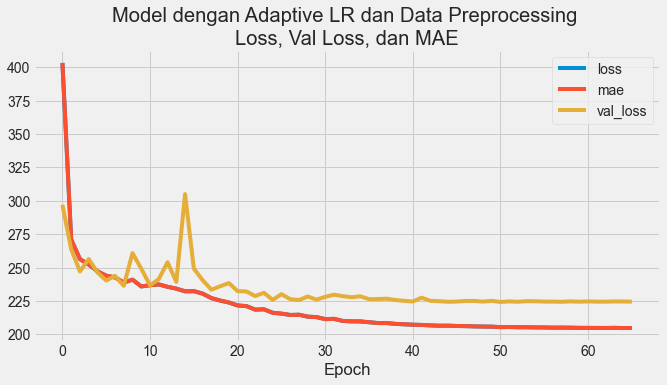

In [125]:
# plot hasil model
pd.DataFrame(history_real_df.history)[['loss', 'mae', 'val_loss']].plot(figsize = (10,5))
plt.title("Model dengan Adaptive LR dan Data Preprocessing \nLoss, Val Loss, dan MAE")
plt.xlabel('Epoch')

In [126]:
pd.DataFrame(history_real_df.history)

loss         mae            mse    val_loss     val_mae  \
0   403.140747  403.140747  698754.562500  296.911377  296.911377   
1   270.963379  270.963379  218154.671875  263.703369  263.703369   
2   256.271423  256.271423  199138.078125  247.031067  247.031067   
3   252.229034  252.229034  193174.593750  256.347504  256.347504   
4   247.157196  247.157196  185662.171875  246.309433  246.309433   
..         ...         ...            ...         ...         ...   
61  204.756195  204.756195  144892.171875  224.447647  224.447647   
62  204.727264  204.727264  144772.546875  224.438232  224.438232   
63  204.816528  204.816528  144959.609375  224.591293  224.591293   
64  204.679321  204.679321  144793.046875  224.559616  224.559616   
65  204.716751  204.716751  144984.906250  224.452271  224.452271   

          val_mse        lr  
0   244597.000000  0.001000  
1   210379.953125  0.001000  
2   196920.015625  0.001000  
3   199613.687500  0.001000  
4   192070.109375  0.001000  
..            ...       ...  
61  169106.328125  0.000009  
62  169150.531250  0.000010  
63  168500.781250  0.000010  
64  169296.234375  0.000010  
65  168855.453125  0.000010  

[66 rows x 7 columns]

In [127]:
# evaluasi hasil model dengan testing data
model1.evaluate(x_test, y_test)

296/296 [==============================] - 1s 2ms/step - loss: 224.5369 - mae: 224.5369 - mse: 166844.0781


[224.53689575195312, 224.53689575195312, 166844.078125]

In [128]:
# buat prediksi dengan testing data dan dibandingkan dengan output asli

prediksi_scaling_lr = pd.DataFrame(model1.predict(x_test)).round(0).astype('int')
prediksi_scaling_lr['asli'] = y_test.reset_index(drop = True)

prediksi_scaling_lr.columns = ['prediksi', 'asli']
prediksi_scaling_lr['selisih_absolut'] = abs(prediksi_scaling_lr['asli'].values - prediksi_scaling_lr['prediksi'].values)
prediksi_scaling_lr['perc_diff'] = (prediksi_scaling_lr['selisih_absolut'].values / prediksi_scaling_lr.asli.values * 100).round(2)
prediksi_scaling_lr

296/296 [==============================] - 1s 2ms/step


prediksi   asli  selisih_absolut  perc_diff
0          795    792                3       0.38
1         4745   4707               38       0.81
2         2590   2593                3       0.12
3         3900   4443              543      12.22
4          860    734              126      17.17
...        ...    ...              ...        ...
9439      1729   1708               21       1.23
9440      9405   9419               14       0.15
9441       431    436                5       1.15
9442      3397   4101              704      17.17
9443     13134  15497             2363      15.25

[9444 rows x 4 columns]

In [129]:
# deskripsi dari data prediksi terhadap data output asli
prediksi_scaling_lr.describe()

prediksi          asli  selisih_absolut    perc_diff
count   9444.000000   9444.000000      9444.000000  9444.000000
mean    3434.221093   3426.227975       224.541825     7.331979
std     3153.407018   3148.496888       341.232462     7.148173
min      348.000000    335.000000         0.000000     0.000000
25%      931.000000    957.000000        42.750000     2.300000
50%     2303.000000   2282.000000       112.000000     5.040000
75%     4906.000000   4872.000000       254.000000    10.010000
max    16959.000000  16492.000000      4707.000000    73.290000

In [130]:
# Hitung metrics untuk lihat kualitas model

# MAE
MAE_scale_adaptive = mean_absolute_error( y_pred = prediksi_scaling_lr.prediksi , y_true = prediksi_scaling_lr.asli )
MAE_scale_adaptive

224.5418254976705

In [131]:
# MSE
MSE_scale_adaptive =mean_squared_error( y_pred = prediksi_scaling_lr.prediksi , y_true = prediksi_scaling_lr.asli )
MSE_scale_adaptive

166846.29510800508

In [132]:
# RMSE
RMSE_scale_adaptive = np.sqrt(mean_squared_error( y_pred = prediksi_scaling_lr.prediksi , y_true = prediksi_scaling_lr.asli ))
RMSE_scale_adaptive

408.4682302309509

In [133]:
# MAPE
MAPE_scale_adaptive = mean_absolute_percentage_error( y_pred = prediksi_scaling_lr.prediksi , y_true = prediksi_scaling_lr.asli )
MAPE_scale_adaptive

0.07331938836540237

In [134]:
# MedAE
medAE_scale_adaptive = median_absolute_error( y_pred = prediksi_scaling_lr.prediksi , y_true = prediksi_scaling_lr.asli )
medAE_scale_adaptive

112.0

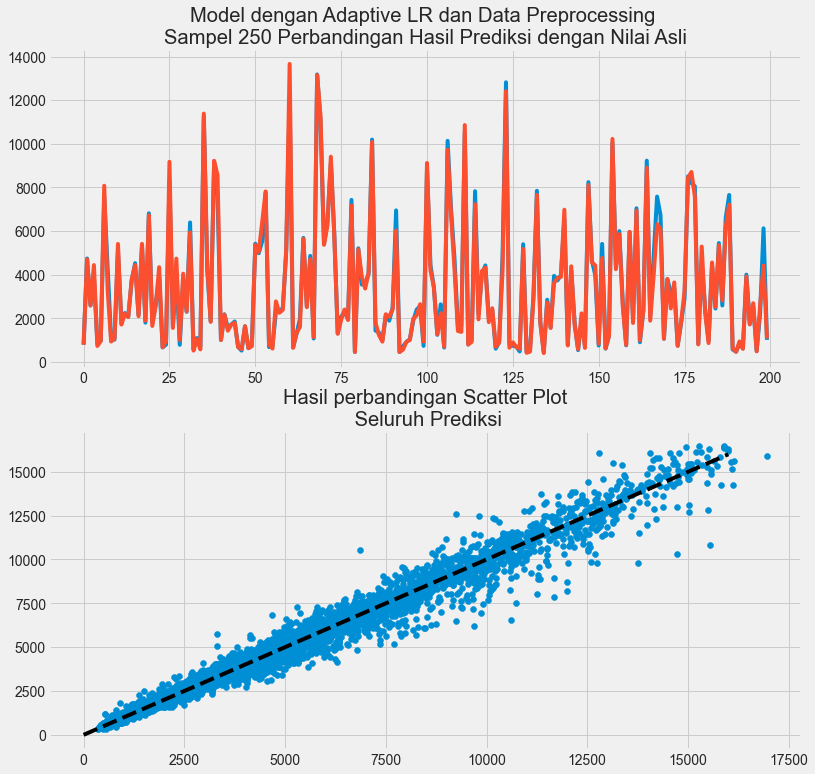

In [135]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(prediksi_scaling_lr.prediksi[:200])
ax[0].plot(prediksi_scaling_lr.asli[:200])
ax[0].title.set_text('Model dengan Adaptive LR dan Data Preprocessing \nSampel 250 Perbandingan Hasil Prediksi dengan Nilai Asli')
ax[1].scatter(x = prediksi_scaling_lr.prediksi, y = prediksi_scaling_lr.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot\n Seluruh Prediksi")
ax[1].plot([0,16000], [0, 16000], c = 'black', ls = '--')

In [136]:
# cari masing masing 250 hasil prediksi terbaik dan terburuk
# berdasarkan nilai persentase perbedaan antara nilai prediksi dan nilai output asli
best250 = prediksi_scaling_lr.sort_values('perc_diff')[:200].reset_index(drop = True)
worst250 = prediksi_scaling_lr.sort_values('perc_diff', ascending = False)[:200].reset_index(drop = True)

In [137]:
# 250 hasil terbaik
best250

prediksi  asli  selisih_absolut  perc_diff
0        1207  1207                0       0.00
1         631   631                0       0.00
2        1444  1444                0       0.00
3         473   473                0       0.00
4        1710  1710                0       0.00
..        ...   ...              ...        ...
195      4483  4476                7       0.16
196      1860  1857                3       0.16
197      5732  5723                9       0.16
198      2519  2515                4       0.16
199      4471  4478                7       0.16

[200 rows x 4 columns]

In [138]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0         811   468              343      73.29
1       10604  6543             4061      62.07
2         566   361              205      56.79
3        9691  6194             3497      56.46
4         530  1186              656      55.31
..        ...   ...              ...        ...
195      6369  5027             1342      26.70
196       499   394              105      26.65
197       466   368               98      26.63
198       723   571              152      26.62
199       604   477              127      26.62

[200 rows x 4 columns]

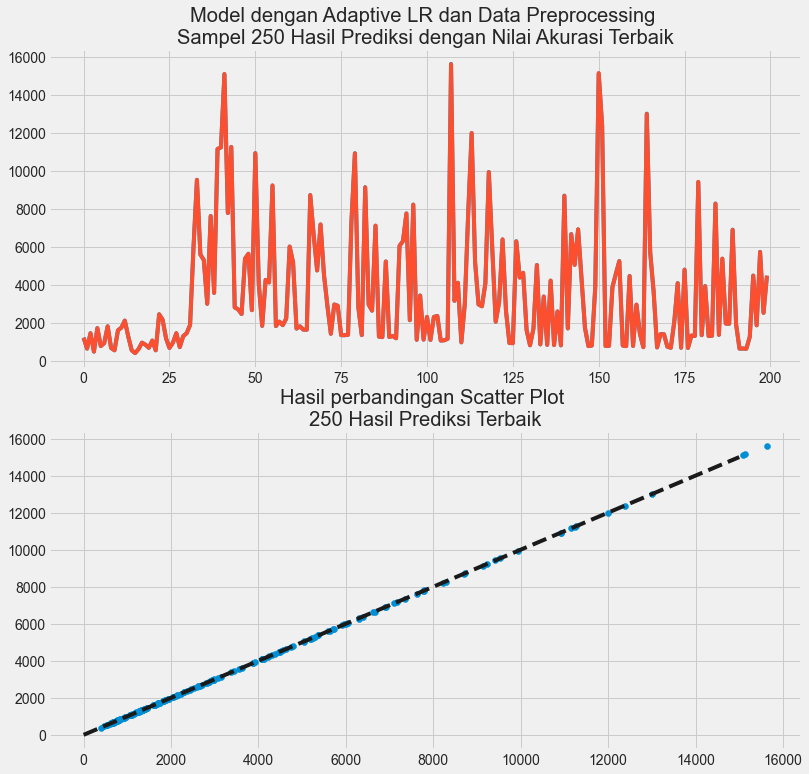

In [139]:
# plot 250 terbaik
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(best250.prediksi)
ax[0].plot(best250.asli)
ax[0].title.set_text('Model dengan Adaptive LR dan Data Preprocessing \nSampel 250 Hasil Prediksi dengan Nilai Akurasi Terbaik')
ax[1].scatter(x = best250.prediksi, y = best250.asli)
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terbaik")

In [140]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0         811   468              343      73.29
1       10604  6543             4061      62.07
2         566   361              205      56.79
3        9691  6194             3497      56.46
4         530  1186              656      55.31
..        ...   ...              ...        ...
195      6369  5027             1342      26.70
196       499   394              105      26.65
197       466   368               98      26.63
198       723   571              152      26.62
199       604   477              127      26.62

[200 rows x 4 columns]

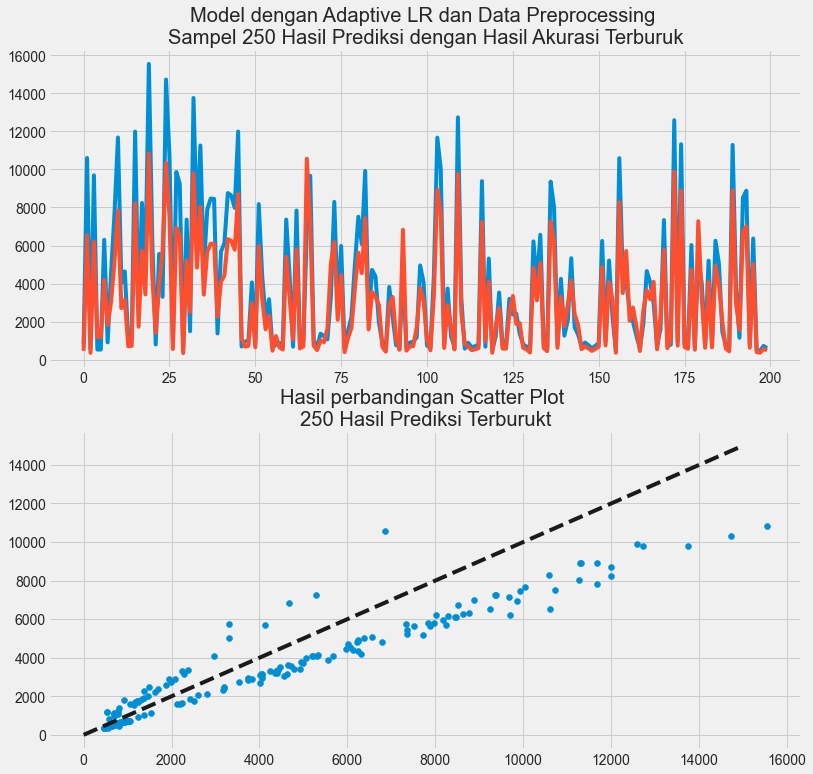

In [141]:
# plot 250 terburuk
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(worst250.prediksi)
ax[0].plot(worst250.asli)
ax[0].title.set_text('Model dengan Adaptive LR dan Data Preprocessing \nSampel 250 Hasil Prediksi dengan Hasil Akurasi Terburuk')
ax[1].scatter(x = worst250.prediksi, y = worst250.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terburukt")
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")

In [143]:
model1.save('model', save_format = 'h5')

### Train Model Tanpa Data Preprocessing

Melakukan hal yang sama seperti sebelumnya namun kali ini dilakukan dengan menggunakan data input yang tidak dihilangkan outliers-nya dan tanpa menggunakan data preprocessing

In [61]:
tf.random.set_seed(42)

model2 = model_arsitektur

model2.compile(loss = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error],
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['mae', 'mse'])



def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr
    if lr < 1e-5:
        return 1e-5
    else:
        return lr * tf.math.exp(-0.1)
        

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
lr_scheduler_riil = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [62]:
history_real_df_nonscale_lr = model2.fit(x_train_outliers, y_train_outliers, validation_split=0.2,
                                        verbose=2, 
                         shuffle=True,  
                         epochs = 100, use_multiprocessing= True, 
                         callbacks = [lr_scheduler_riil, early_stopping])

Epoch 1/100
1076/1076 - 4s - loss: 764.8857 - mae: 764.8857 - mse: 2709430.0000 - val_loss: 632.7599 - val_mae: 632.7599 - val_mse: 1345963.8750 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 2/100
1076/1076 - 3s - loss: 627.1890 - mae: 627.1890 - mse: 1661141.1250 - val_loss: 573.0029 - val_mae: 573.0029 - val_mse: 1127741.0000 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 3/100
1076/1076 - 3s - loss: 625.8184 - mae: 625.8184 - mse: 1671036.5000 - val_loss: 570.0518 - val_mae: 570.0518 - val_mse: 1151643.5000 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 4/100
1076/1076 - 4s - loss: 599.7617 - mae: 599.7617 - mse: 1481889.2500 - val_loss: 575.7585 - val_mae: 575.7585 - val_mse: 1181907.6250 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 5/100
1076/1076 - 3s - loss: 600.7709 - mae: 600.7709 - mse: 1433014.3750 - val_loss: 564.4577 - val_mae: 564.4577 - val_mse: 1157841.0000 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 6/100
1076/1076 - 3s - loss: 590.5940 - mae: 590.5940 - mse: 1367347.5000 - val_loss: 532.9431

Text(0.5, 0, 'Epoch')

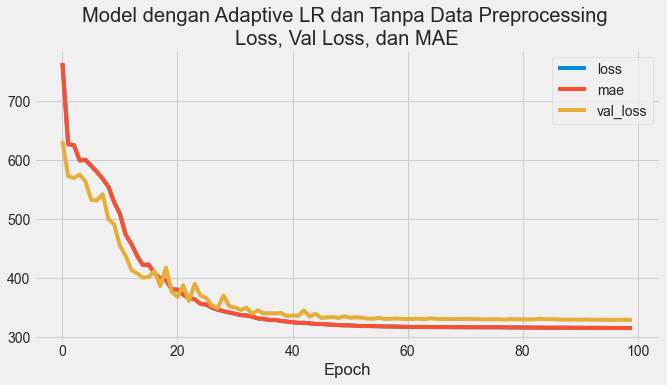

In [63]:
# plot hasil model
pd.DataFrame(history_real_df_nonscale_lr.history)[['loss', 'mae', 'val_loss']].plot(figsize = (10,5))
plt.title("Model dengan Adaptive LR dan Tanpa Data Preprocessing \nLoss, Val Loss, dan MAE")
plt.xlabel('Epoch')

In [64]:
pd.DataFrame(history_real_df_nonscale_lr.history)

loss         mae           mse    val_loss     val_mae  \
0   764.885681  764.885681  2.709430e+06  632.759949  632.759949   
1   627.188965  627.188965  1.661141e+06  573.002930  573.002930   
2   625.818359  625.818359  1.671036e+06  570.051758  570.051758   
3   599.761719  599.761719  1.481889e+06  575.758484  575.758484   
4   600.770874  600.770874  1.433014e+06  564.457703  564.457703   
..         ...         ...           ...         ...         ...   
95  315.929474  315.929474  3.781573e+05  329.743622  329.743622   
96  315.887878  315.887878  3.777478e+05  329.620789  329.620789   
97  315.885834  315.885834  3.780453e+05  329.615753  329.615753   
98  315.796997  315.796997  3.784564e+05  329.947876  329.947876   
99  315.813202  315.813202  3.775112e+05  329.540985  329.540985   

         val_mse       lr  
0   1.345964e+06  0.00100  
1   1.127741e+06  0.00100  
2   1.151644e+06  0.00100  
3   1.181908e+06  0.00100  
4   1.157841e+06  0.00100  
..           ...      ...  
95  4.565164e+05  0.00001  
96  4.556500e+05  0.00001  
97  4.549079e+05  0.00001  
98  4.538849e+05  0.00001  
99  4.550103e+05  0.00001  

[100 rows x 7 columns]

In [65]:
# evaluasi hasil model dengan testing data
model2.evaluate(x_test_outliers, y_test_outliers)

337/337 [==============================] - 1s 2ms/step - loss: 310.5385 - mae: 310.5385 - mse: 373073.3750


[310.5384826660156, 310.5384826660156, 373073.375]

In [66]:
# buat prediksi dengan testing data dan dibandingkan dengan output asli

prediksi_nonscale_lr = pd.DataFrame(model2.predict(x_test_outliers)).round(0).astype('int')
prediksi_nonscale_lr['asli'] = y_test_outliers.reset_index(drop = True)

prediksi_nonscale_lr.columns = ['prediksi', 'asli']
prediksi_nonscale_lr['selisih_absolut'] = abs(prediksi_nonscale_lr['asli'].values - prediksi_nonscale_lr['prediksi'].values)
prediksi_nonscale_lr['perc_diff'] = (prediksi_nonscale_lr['selisih_absolut'].values / prediksi_nonscale_lr.asli.values * 100).round(2)
prediksi_nonscale_lr

337/337 [==============================] - 1s 2ms/step


prediksi   asli  selisih_absolut  perc_diff
0          1773   1435              338      23.55
1          3533   3584               51       1.42
2          1856   1851                5       0.27
3          1659   1590               69       4.34
4          5443   5690              247       4.34
...         ...    ...              ...        ...
10754      1287   1249               38       3.04
10755      1571   1428              143      10.01
10756       872    912               40       4.39
10757     14987  15002               15       0.10
10758      1021   1071               50       4.67

[10759 rows x 4 columns]

In [67]:
# deskripsi dari data prediksi terhadap data output asli
prediksi_nonscale_lr.describe()

prediksi          asli  selisih_absolut     perc_diff
count  10759.000000  10759.000000     10759.000000  10759.000000
mean    3890.546333   3885.793568       310.536202      8.833581
std     3898.297481   3904.290849       525.988703      8.702465
min      328.000000    335.000000         0.000000      0.000000
25%      927.000000    952.500000        58.000000      2.895000
50%     2420.000000   2436.000000       135.000000      6.520000
75%     5224.000000   5246.500000       335.500000     12.440000
max    19159.000000  18791.000000     12756.000000    317.360000

In [68]:
# Hitung metrics untuk lihat kualitas model

# MAE
MAE_nonscale_adaptive = mean_absolute_error( y_pred = prediksi_nonscale_lr.prediksi , y_true = prediksi_nonscale_lr.asli )
MAE_nonscale_adaptive

310.53620224927965

In [69]:
# MSE
MSE_nonscale_adaptive =mean_squared_error( y_pred = prediksi_nonscale_lr.prediksi , y_true = prediksi_nonscale_lr.asli )
MSE_nonscale_adaptive

373071.13402732596

In [70]:
# RMSE
RMSE_nonscale_adaptive = np.sqrt(mean_squared_error( y_pred = prediksi_nonscale_lr.prediksi , y_true = prediksi_nonscale_lr.asli ))
RMSE_nonscale_adaptive

610.795492802072

In [71]:
# MAPE
MAPE_nonscale_adaptive = mean_absolute_percentage_error( y_pred = prediksi_nonscale_lr.prediksi , y_true = prediksi_nonscale_lr.asli )
MAPE_nonscale_adaptive

0.0883359818195537

In [72]:
# MedAE
medAE_nonscale_adaptive = median_absolute_error( y_pred = prediksi_nonscale_lr.prediksi , y_true = prediksi_nonscale_lr.asli )
medAE_nonscale_adaptive

135.0

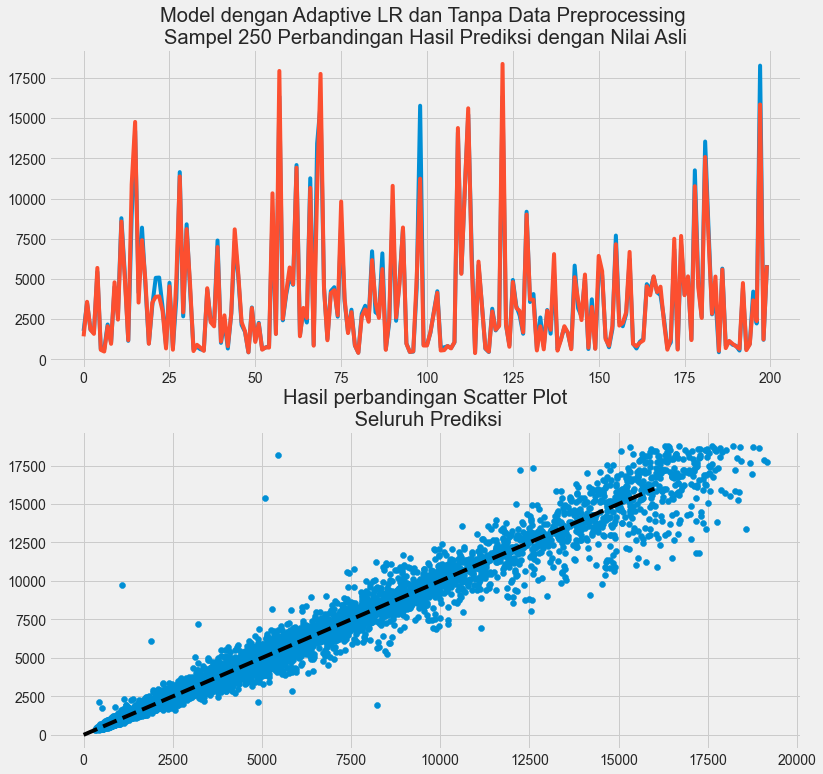

In [73]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(prediksi_nonscale_lr.prediksi[:200])
ax[0].plot(prediksi_nonscale_lr.asli[:200])
ax[0].title.set_text('Model dengan Adaptive LR dan Tanpa Data Preprocessing \nSampel 250 Perbandingan Hasil Prediksi dengan Nilai Asli')
ax[1].scatter(x = prediksi_nonscale_lr.prediksi, y = prediksi_nonscale_lr.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot\n Seluruh Prediksi")
ax[1].plot([0,16000], [0, 16000], c = 'black', ls = '--')

In [74]:
# cari masing masing 250 hasil prediksi terbaik dan terburuk
# berdasarkan nilai persentase perbedaan antara nilai prediksi dan nilai output asli
best250 = prediksi_nonscale_lr.sort_values('perc_diff')[:200].reset_index(drop = True)
worst250 = prediksi_nonscale_lr.sort_values('perc_diff', ascending = False)[:200].reset_index(drop = True)

In [75]:
# 250 hasil terbaik
best250

prediksi  asli  selisih_absolut  perc_diff
0         645   645                0       0.00
1        3997  3997                0       0.00
2        4915  4915                0       0.00
3        1717  1717                0       0.00
4         984   984                0       0.00
..        ...   ...              ...        ...
195       469   470                1       0.21
196      4752  4742               10       0.21
197      4309  4318                9       0.21
198      5328  5317               11       0.21
199      4243  4234                9       0.21

[200 rows x 4 columns]

In [76]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0        8222  1970             6252     317.36
1        4902  2130             2772     130.14
2        5843  2845             2998     105.38
3        1089  9752             8663      88.83
4         443  2160             1717      79.49
..        ...   ...              ...        ...
195       607   462              145      31.39
196      4855  3696             1159      31.36
197       872   664              208      31.33
198      1974  2872              898      31.27
199       941   717              224      31.24

[200 rows x 4 columns]

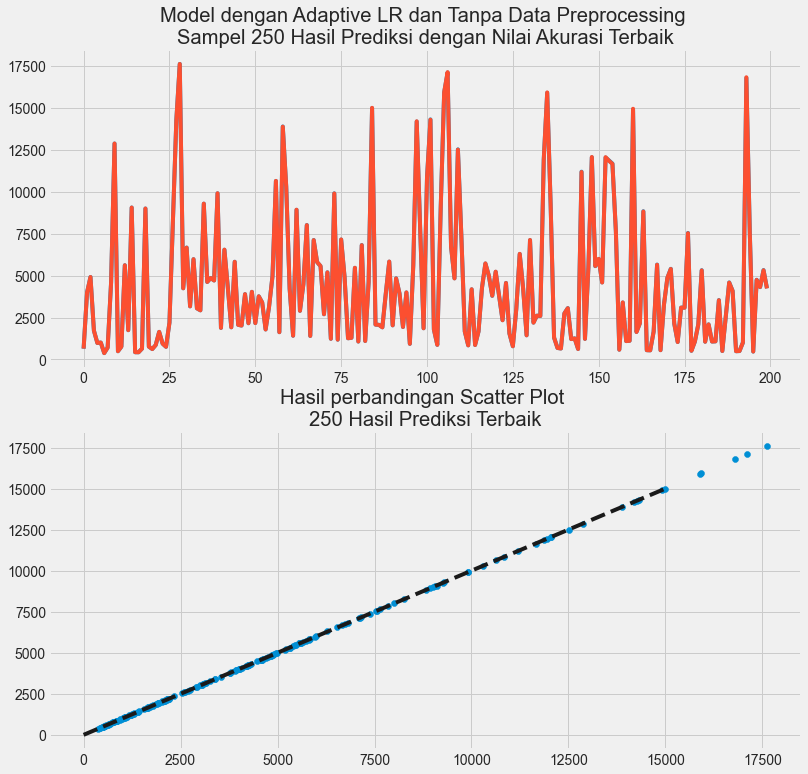

In [77]:
# plot 250 terbaik
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(best250.prediksi)
ax[0].plot(best250.asli)
ax[0].title.set_text('Model dengan Adaptive LR dan Tanpa Data Preprocessing \nSampel 250 Hasil Prediksi dengan Nilai Akurasi Terbaik')
ax[1].scatter(x = best250.prediksi, y = best250.asli)
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terbaik")

In [78]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0        8222  1970             6252     317.36
1        4902  2130             2772     130.14
2        5843  2845             2998     105.38
3        1089  9752             8663      88.83
4         443  2160             1717      79.49
..        ...   ...              ...        ...
195       607   462              145      31.39
196      4855  3696             1159      31.36
197       872   664              208      31.33
198      1974  2872              898      31.27
199       941   717              224      31.24

[200 rows x 4 columns]

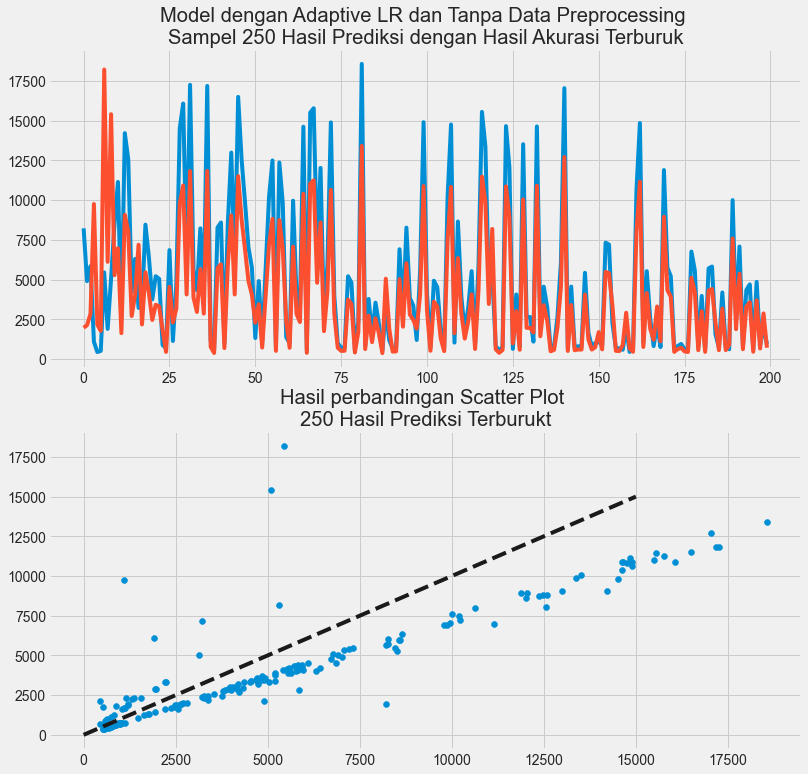

In [79]:
# plot 250 terburuk
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(worst250.prediksi)
ax[0].plot(worst250.asli)
ax[0].title.set_text('Model dengan Adaptive LR dan Tanpa Data Preprocessing \nSampel 250 Hasil Prediksi dengan Hasil Akurasi Terburuk')
ax[1].scatter(x = worst250.prediksi, y = worst250.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terburukt")
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")

## Tanpa Adaptive Learning Rate

#### Train Model data dengan Data Preprocessing

In [80]:
tf.random.set_seed(42)

model3 = model_arsitektur

model3.compile(loss = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error],
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['mae', 'mse'])



early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)

In [81]:
# train model
history_real_scale_nonlr = model3.fit(x_train, y_train, validation_split=0.2, verbose=2, 
                                     shuffle=True, epochs = 300, use_multiprocessing= True, 
                                     callbacks = [early_stopping])

Epoch 1/300
945/945 - 4s - loss: 441.1664 - mae: 441.1664 - mse: 670424.0625 - val_loss: 347.7267 - val_mae: 347.7267 - val_mse: 346570.6875 - 4s/epoch - 5ms/step
Epoch 2/300
945/945 - 4s - loss: 343.4181 - mae: 343.4181 - mse: 338162.2500 - val_loss: 353.3163 - val_mae: 353.3163 - val_mse: 364321.8438 - 4s/epoch - 4ms/step
Epoch 3/300
945/945 - 3s - loss: 316.0782 - mae: 316.0782 - mse: 294878.2188 - val_loss: 297.6157 - val_mae: 297.6157 - val_mse: 270191.0312 - 3s/epoch - 3ms/step
Epoch 4/300
945/945 - 2s - loss: 310.1758 - mae: 310.1758 - mse: 284396.3750 - val_loss: 394.1639 - val_mae: 394.1639 - val_mse: 417810.5625 - 2s/epoch - 2ms/step
Epoch 5/300
945/945 - 3s - loss: 301.5625 - mae: 301.5625 - mse: 267243.0312 - val_loss: 284.9705 - val_mae: 284.9705 - val_mse: 259373.3594 - 3s/epoch - 3ms/step
Epoch 6/300
945/945 - 3s - loss: 295.0802 - mae: 295.0802 - mse: 259564.0469 - val_loss: 289.6000 - val_mae: 289.6000 - val_mse: 235898.4531 - 3s/epoch - 4ms/step
Epoch 7/300
945/945 - 

Text(0.5, 0, 'Epoch')

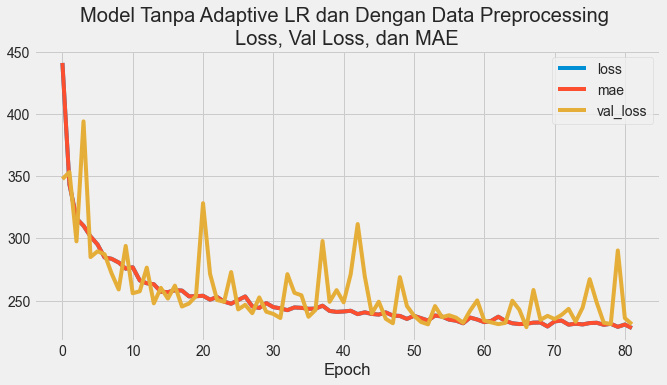

In [82]:
# plot hasil model
pd.DataFrame(history_real_scale_nonlr.history)[['loss', 'mae', 'val_loss']].plot(figsize = (10,5))
plt.title("Model Tanpa Adaptive LR dan Dengan Data Preprocessing \nLoss, Val Loss, dan MAE")
plt.xlabel('Epoch')

In [83]:
pd.DataFrame(history_real_scale_nonlr.history)

loss         mae            mse    val_loss     val_mae  \
0   441.166382  441.166382  670424.062500  347.726715  347.726715   
1   343.418091  343.418091  338162.250000  353.316254  353.316254   
2   316.078217  316.078217  294878.218750  297.615662  297.615662   
3   310.175842  310.175842  284396.375000  394.163879  394.163879   
4   301.562500  301.562500  267243.031250  284.970490  284.970490   
..         ...         ...            ...         ...         ...   
77  230.485687  230.485687  169709.296875  232.155472  232.155472   
78  231.273972  231.273972  171198.703125  231.106964  231.106964   
79  228.842850  228.842850  167597.781250  290.293915  290.293915   
80  230.684204  230.684204  169375.734375  235.867737  235.867737   
81  227.857132  227.857132  166140.015625  230.922989  230.922989   

          val_mse  
0   346570.687500  
1   364321.843750  
2   270191.031250  
3   417810.562500  
4   259373.359375  
..            ...  
77  172988.375000  
78  167755.468750  
79  253276.593750  
80  189365.140625  
81  173207.750000  

[82 rows x 6 columns]

In [84]:
# evaluasi hasil model dengan testing data
model3.evaluate(x_test, y_test)

296/296 [==============================] - 1s 2ms/step - loss: 229.4996 - mae: 229.4996 - mse: 168105.2500


[229.49957275390625, 229.49957275390625, 168105.25]

In [85]:
# buat prediksi dengan testing data dan dibandingkan dengan output asli

prediksi_scaling_nonlr = pd.DataFrame(model3.predict(x_test)).round(0).astype('int')
prediksi_scaling_nonlr['asli'] = y_test.reset_index(drop = True)

prediksi_scaling_nonlr.columns = ['prediksi', 'asli']
prediksi_scaling_nonlr['selisih_absolut'] = abs(prediksi_scaling_nonlr['asli'].values - prediksi_scaling_nonlr['prediksi'].values)
prediksi_scaling_nonlr['perc_diff'] = (prediksi_scaling_nonlr['selisih_absolut'].values / prediksi_scaling_nonlr.asli.values * 100).round(2)
prediksi_scaling_nonlr

296/296 [==============================] - 1s 2ms/step


prediksi   asli  selisih_absolut  perc_diff
0          779    792               13       1.64
1         4816   4707              109       2.32
2         2631   2593               38       1.47
3         4095   4443              348       7.83
4          844    734              110      14.99
...        ...    ...              ...        ...
9439      1694   1708               14       0.82
9440      9192   9419              227       2.41
9441       453    436               17       3.90
9442      3488   4101              613      14.95
9443     13845  15497             1652      10.66

[9444 rows x 4 columns]

In [86]:
# deskripsi dari data prediksi terhadap data output asli
prediksi_scaling_nonlr.describe()

prediksi          asli  selisih_absolut    perc_diff
count   9444.000000   9444.000000      9444.000000  9444.000000
mean    3418.230729   3426.227975       229.502118     7.486817
std     3117.172504   3148.496888       339.774381     7.007044
min      367.000000    335.000000         0.000000     0.000000
25%      923.000000    957.000000        45.000000     2.500000
50%     2322.000000   2282.000000       114.000000     5.350000
75%     4888.000000   4872.000000       258.000000    10.450000
max    16632.000000  16492.000000      4653.000000   117.950000

In [87]:
# Hitung metrics untuk lihat kualitas model

# MAE
MAE_scale_nonadaptive = mean_absolute_error( y_pred = prediksi_scaling_nonlr.prediksi , y_true = prediksi_scaling_nonlr.asli )
MAE_scale_nonadaptive

229.5021177467175

In [88]:
# MSE
MSE_scale_nonadaptive =mean_squared_error( y_pred = prediksi_scaling_nonlr.prediksi , y_true = prediksi_scaling_nonlr.asli )
MSE_scale_nonadaptive

168105.62791190174

In [89]:
# RMSE
RMSE_scale_nonadaptive = np.sqrt(mean_squared_error( y_pred = prediksi_scaling_nonlr.prediksi , y_true = prediksi_scaling_nonlr.asli ))
RMSE_scale_nonadaptive

410.0068632497531

In [90]:
# MAPE
MAPE_scale_nonadaptive = mean_absolute_percentage_error( y_pred = prediksi_scaling_nonlr.prediksi , y_true = prediksi_scaling_nonlr.asli )
MAPE_scale_nonadaptive

0.07486813498445832

In [91]:
# MedAE
medAE_scale_nonadaptive = median_absolute_error( y_pred = prediksi_scaling_nonlr.prediksi , y_true = prediksi_scaling_nonlr.asli )
medAE_scale_nonadaptive

114.0

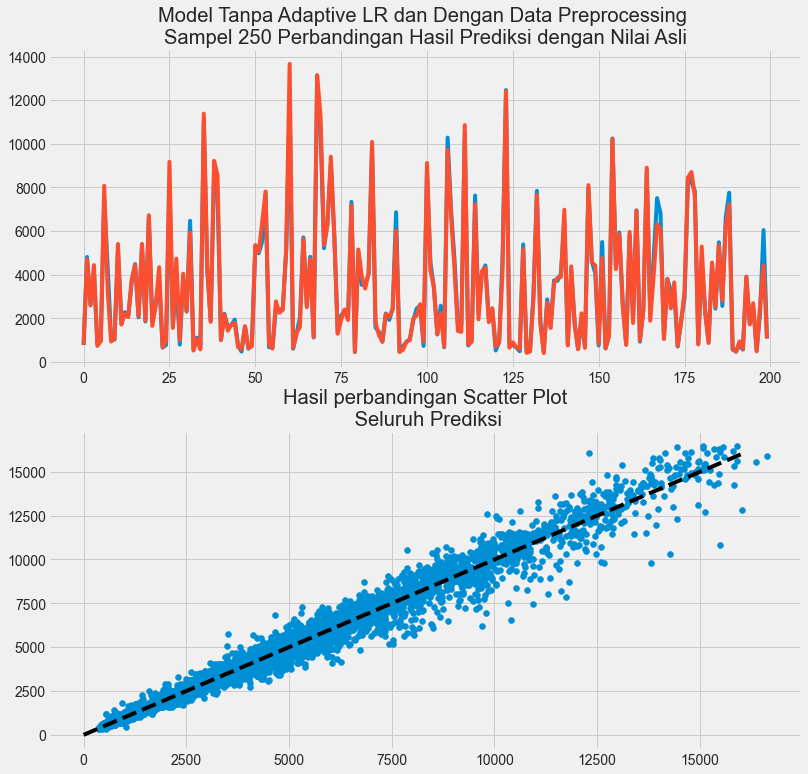

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(prediksi_scaling_nonlr.prediksi[:200])
ax[0].plot(prediksi_scaling_nonlr.asli[:200])
ax[0].title.set_text('Model Tanpa Adaptive LR dan Dengan Data Preprocessing \nSampel 250 Perbandingan Hasil Prediksi dengan Nilai Asli')
ax[1].scatter(x = prediksi_scaling_nonlr.prediksi, y = prediksi_scaling_nonlr.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot\n Seluruh Prediksi")
ax[1].plot([0,16000], [0, 16000], c = 'black', ls = '--')

In [93]:
# cari masing masing 250 hasil prediksi terbaik dan terburuk
# berdasarkan nilai persentase perbedaan antara nilai prediksi dan nilai output asli
best250 = prediksi_scaling_nonlr.sort_values('perc_diff')[:200].reset_index(drop = True)
worst250 = prediksi_scaling_nonlr.sort_values('perc_diff', ascending = False)[:200].reset_index(drop = True)

In [94]:
# 250 hasil terbaik
best250

prediksi  asli  selisih_absolut  perc_diff
0         477   477                0       0.00
1         506   506                0       0.00
2        2002  2002                0       0.00
3         984   984                0       0.00
4        1095  1095                0       0.00
..        ...   ...              ...        ...
195       499   500                1       0.20
196       501   502                1       0.20
197       940   938                2       0.21
198      9032  9013               19       0.21
199      7044  7059               15       0.21

[200 rows x 4 columns]

In [95]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0        1020   468              552     117.95
1       10408  6543             3865      59.07
2        9708  6194             3514      56.73
3         537  1186              649      54.72
4         542  1186              644      54.30
..        ...   ...              ...        ...
195       771  1040              269      25.87
196       711   565              146      25.84
197      1655  1316              339      25.76
198       767  1033              266      25.75
199      1167  1571              404      25.72

[200 rows x 4 columns]

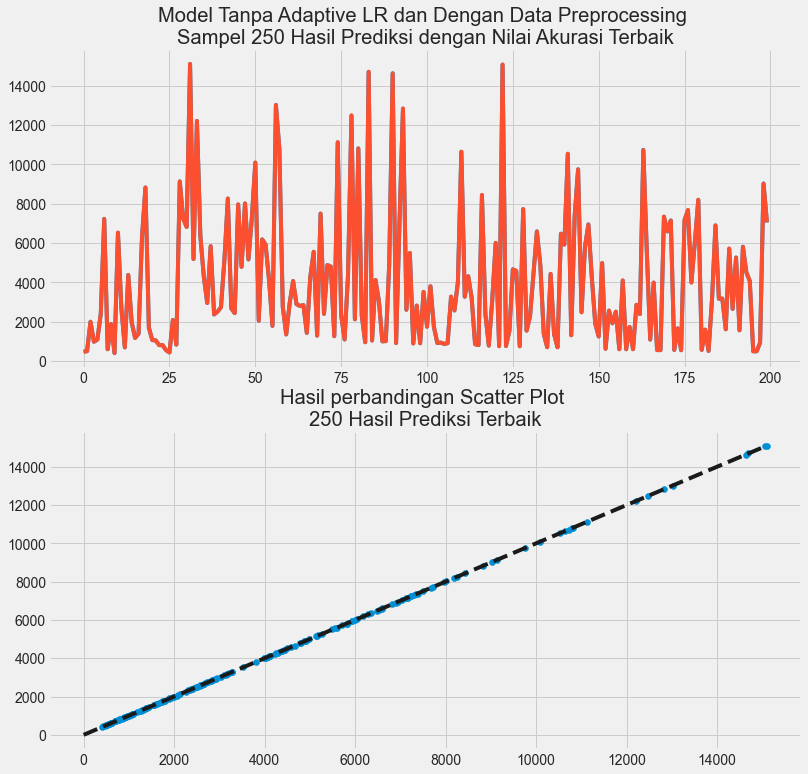

In [96]:
# plot 250 terbaik
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(best250.prediksi)
ax[0].plot(best250.asli)
ax[0].title.set_text('Model Tanpa Adaptive LR dan Dengan Data Preprocessing \nSampel 250 Hasil Prediksi dengan Nilai Akurasi Terbaik')
ax[1].scatter(x = best250.prediksi, y = best250.asli)
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terbaik")

In [97]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0        1020   468              552     117.95
1       10408  6543             3865      59.07
2        9708  6194             3514      56.73
3         537  1186              649      54.72
4         542  1186              644      54.30
..        ...   ...              ...        ...
195       771  1040              269      25.87
196       711   565              146      25.84
197      1655  1316              339      25.76
198       767  1033              266      25.75
199      1167  1571              404      25.72

[200 rows x 4 columns]

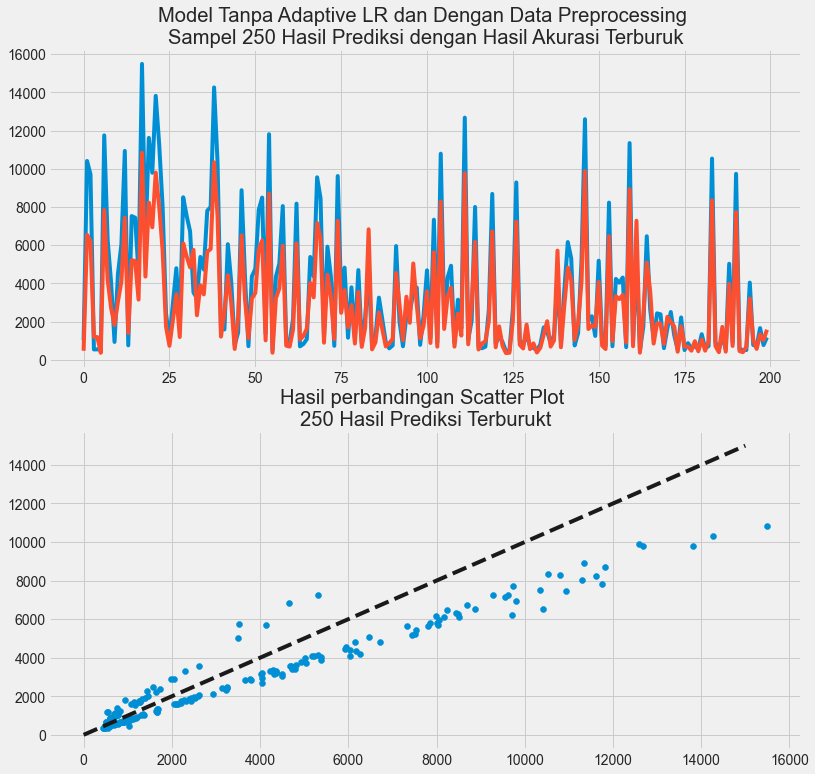

In [98]:
# plot 250 terburuk
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(worst250.prediksi)
ax[0].plot(worst250.asli)
ax[0].title.set_text('Model Tanpa Adaptive LR dan Dengan Data Preprocessing \nSampel 250 Hasil Prediksi dengan Hasil Akurasi Terburuk')
ax[1].scatter(x = worst250.prediksi, y = worst250.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terburukt")
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")

### Train Model Tanpa Data Preprocessing

Melakukan hal yang sama seperti sebelumnya namun kali ini dilakukan dengan menggunakan data input yang tidak dihilangkan outliers-nya dam tidak dilakukan data preprocessing

In [99]:
tf.random.set_seed(42)

model4 = model_arsitektur

model4.compile(loss = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error],
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['mae', 'mse'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)

In [100]:
history_real_df_nonscale_nonlr = model4.fit(x_train_outliers, y_train_outliers,
                                           validation_split=0.2, verbose=2, 
                         shuffle=True,  
                         epochs = 100, use_multiprocessing= True, 
                         callbacks = [early_stopping])

Epoch 1/100
1076/1076 - 5s - loss: 643.4567 - mae: 643.4567 - mse: 1556665.5000 - val_loss: 559.2502 - val_mae: 559.2502 - val_mse: 1200838.5000 - 5s/epoch - 4ms/step
Epoch 2/100
1076/1076 - 4s - loss: 561.9048 - mae: 561.9048 - mse: 1165194.8750 - val_loss: 535.6154 - val_mae: 535.6154 - val_mse: 1061241.3750 - 4s/epoch - 3ms/step
Epoch 3/100
1076/1076 - 4s - loss: 543.1849 - mae: 543.1849 - mse: 1151344.8750 - val_loss: 552.5067 - val_mae: 552.5067 - val_mse: 1198774.3750 - 4s/epoch - 4ms/step
Epoch 4/100
1076/1076 - 4s - loss: 498.2154 - mae: 498.2154 - mse: 953326.9375 - val_loss: 514.5380 - val_mae: 514.5380 - val_mse: 995835.0000 - 4s/epoch - 4ms/step
Epoch 5/100
1076/1076 - 4s - loss: 471.0465 - mae: 471.0465 - mse: 826380.1250 - val_loss: 559.1259 - val_mae: 559.1259 - val_mse: 1196184.0000 - 4s/epoch - 4ms/step
Epoch 6/100
1076/1076 - 4s - loss: 445.0850 - mae: 445.0850 - mse: 702879.5000 - val_loss: 439.1606 - val_mae: 439.1606 - val_mse: 755196.3125 - 4s/epoch - 4ms/step
Epo

Text(0.5, 0, 'Epoch')

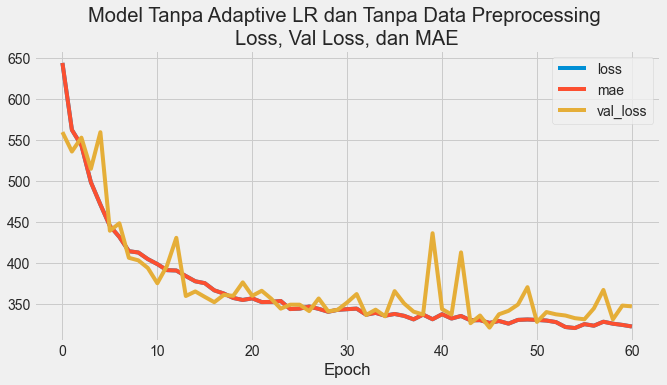

In [101]:
# plot hasil model
pd.DataFrame(history_real_df_nonscale_nonlr.history)[['loss', 'mae', 'val_loss']].plot(figsize = (10,5))
plt.title("Model Tanpa Adaptive LR dan Tanpa Data Preprocessing \nLoss, Val Loss, dan MAE")
plt.xlabel('Epoch')

In [102]:
pd.DataFrame(history_real_df_nonscale_nonlr.history)

loss         mae           mse    val_loss     val_mae       val_mse
0   643.456665  643.456665  1.556666e+06  559.250244  559.250244  1.200838e+06
1   561.904785  561.904785  1.165195e+06  535.615356  535.615356  1.061241e+06
2   543.184875  543.184875  1.151345e+06  552.506653  552.506653  1.198774e+06
3   498.215393  498.215393  9.533269e+05  514.538025  514.538025  9.958350e+05
4   471.046539  471.046539  8.263801e+05  559.125854  559.125854  1.196184e+06
..         ...         ...           ...         ...         ...           ...
56  323.544922  323.544922  3.873948e+05  344.662842  344.662842  4.522525e+05
57  328.391602  328.391602  4.047881e+05  367.084045  367.084045  5.340880e+05
58  326.006622  326.006622  4.025997e+05  331.246674  331.246674  4.516050e+05
59  324.503326  324.503326  3.862857e+05  348.065369  348.065369  5.198177e+05
60  322.584412  322.584412  3.903105e+05  347.082855  347.082855  4.699964e+05

[61 rows x 6 columns]

In [103]:
# evaluasi hasil model dengan testing data
model4.evaluate(x_test_outliers, y_test_outliers)

337/337 [==============================] - 1s 2ms/step - loss: 326.1846 - mae: 326.1846 - mse: 390751.1562


[326.1846008300781, 326.1846008300781, 390751.15625]

In [105]:
# buat prediksi dengan testing data dan dibandingkan dengan output asli

prediksi_nonscale_nonlr = pd.DataFrame(model4.predict(x_test_outliers)).round(0).astype('int')
prediksi_nonscale_nonlr['asli'] = y_test_outliers.reset_index(drop = True)

prediksi_nonscale_nonlr.columns = ['prediksi', 'asli']
prediksi_nonscale_nonlr['selisih_absolut'] = abs(prediksi_nonscale_nonlr['asli'].values - prediksi_nonscale_nonlr['prediksi'].values)
prediksi_nonscale_nonlr['perc_diff'] = (prediksi_nonscale_nonlr['selisih_absolut'].values / prediksi_nonscale_nonlr.asli.values * 100).round(2)
prediksi_nonscale_nonlr

337/337 [==============================] - 1s 2ms/step


prediksi   asli  selisih_absolut  perc_diff
0          1806   1435              371      25.85
1          3686   3584              102       2.85
2          1928   1851               77       4.16
3          1760   1590              170      10.69
4          5647   5690               43       0.76
...         ...    ...              ...        ...
10754      1270   1249               21       1.68
10755      1586   1428              158      11.06
10756       946    912               34       3.73
10757     14791  15002              211       1.41
10758      1108   1071               37       3.45

[10759 rows x 4 columns]

In [106]:
# deskripsi dari data prediksi terhadap data output asli
prediksi_nonscale_nonlr.describe()

prediksi          asli  selisih_absolut     perc_diff
count  10759.000000  10759.000000     10759.000000  10759.000000
mean    4016.172042   3885.793568       326.187192      9.185788
std     3987.521876   3904.290849       533.273015      8.645727
min      347.000000    335.000000         0.000000      0.000000
25%      930.500000    952.500000        60.000000      3.200000
50%     2547.000000   2436.000000       140.000000      6.930000
75%     5448.000000   5246.500000       376.000000     12.860000
max    20290.000000  18791.000000     11344.000000    206.900000

In [107]:
# Hitung metrics untuk lihat kualitas model

# MAE
MAE_nonscale_nonadaptive = mean_absolute_error( y_pred = prediksi_nonscale_nonlr.prediksi , y_true = prediksi_nonscale_nonlr.asli )
MAE_nonscale_nonadaptive

326.1871921182266

In [108]:
# MSE
MSE_nonscale_nonadaptive =mean_squared_error( y_pred = prediksi_nonscale_nonlr.prediksi , y_true = prediksi_nonscale_nonlr.asli )
MSE_nonscale_nonadaptive

390751.7607584348

In [109]:
# RMSE
RMSE_nonscale_nonadaptive = np.sqrt(mean_squared_error( y_pred = prediksi_nonscale_nonlr.prediksi , y_true = prediksi_nonscale_nonlr.asli ))
RMSE_nonscale_nonadaptive

625.101400381118

In [110]:
# MAPE
MAPE_nonscale_nonadaptive = mean_absolute_percentage_error( y_pred = prediksi_nonscale_nonlr.prediksi , y_true = prediksi_nonscale_nonlr.asli )
MAPE_nonscale_nonadaptive

0.09185802072486882

In [111]:
# MedAE
medAE_nonscale_nonadaptive = median_absolute_error( y_pred = prediksi_nonscale_nonlr.prediksi , y_true = prediksi_nonscale_nonlr.asli )
medAE_nonscale_nonadaptive

140.0

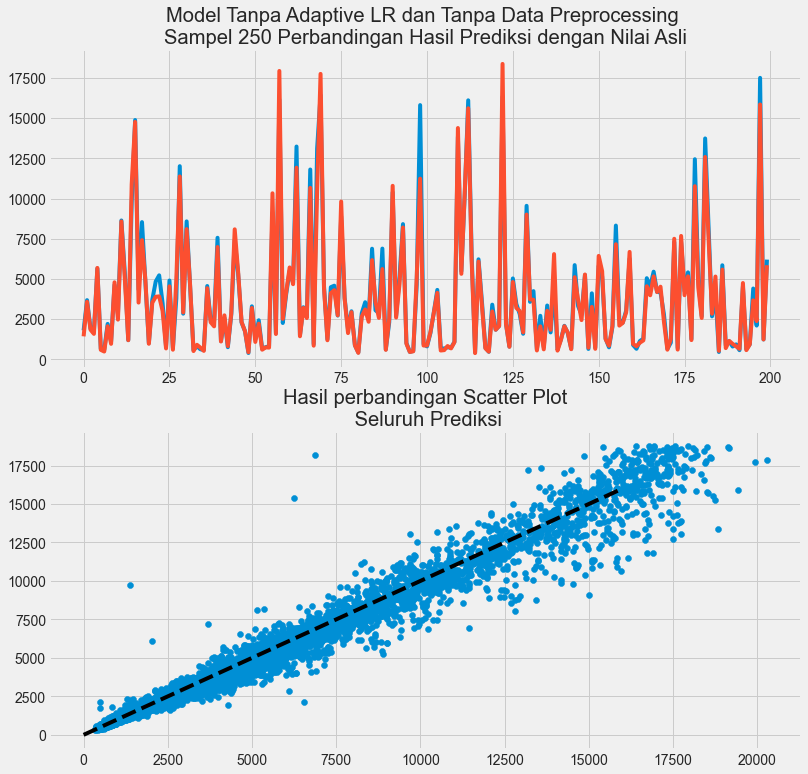

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(prediksi_nonscale_nonlr.prediksi[:200])
ax[0].plot(prediksi_nonscale_nonlr.asli[:200])
ax[0].title.set_text('Model Tanpa Adaptive LR dan Tanpa Data Preprocessing \nSampel 250 Perbandingan Hasil Prediksi dengan Nilai Asli')
ax[1].scatter(x = prediksi_nonscale_nonlr.prediksi, y = prediksi_nonscale_nonlr.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot\n Seluruh Prediksi")
ax[1].plot([0,16000], [0, 16000], c = 'black', ls = '--')

In [113]:
# cari masing masing 250 hasil prediksi terbaik dan terburuk
# berdasarkan nilai persentase perbedaan antara nilai prediksi dan nilai output asli
best250 = prediksi_nonscale_nonlr.sort_values('perc_diff')[:200].reset_index(drop = True)
worst250 = prediksi_nonscale_nonlr.sort_values('perc_diff', ascending = False)[:200].reset_index(drop = True)

In [114]:
# 250 hasil terbaik
best250

prediksi   asli  selisih_absolut  perc_diff
0        3640   3640                0       0.00
1        1767   1767                0       0.00
2        1387   1387                0       0.00
3        2604   2604                0       0.00
4        1957   1957                0       0.00
..        ...    ...              ...        ...
195      5149   5161               12       0.23
196     10631  10655               24       0.23
197      1237   1240                3       0.24
198      4527   4516               11       0.24
199      2071   2066                5       0.24

[200 rows x 4 columns]

In [115]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0        6537  2130             4407     206.90
1        4296  1970             2326     118.07
2        6100  2845             3255     114.41
3        1383  9752             8369      85.82
4         498  2160             1662      76.94
..        ...   ...              ...        ...
195      3071  2295              776      33.81
196     10148  7585             2563      33.79
197      3259  2438              821      33.68
198      6248  4677             1571      33.59
199      5550  4155             1395      33.57

[200 rows x 4 columns]

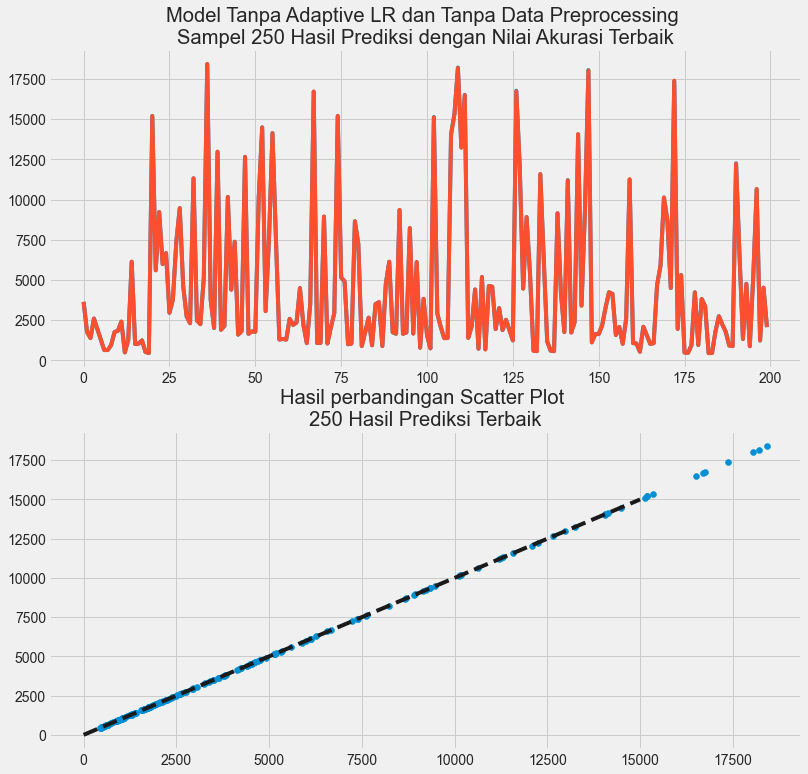

In [116]:
# plot 250 terbaik
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(best250.prediksi)
ax[0].plot(best250.asli)
ax[0].title.set_text('Model Tanpa Adaptive LR dan Tanpa Data Preprocessing \nSampel 250 Hasil Prediksi dengan Nilai Akurasi Terbaik')
ax[1].scatter(x = best250.prediksi, y = best250.asli)
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terbaik")

In [117]:
# 250 hasil terburuk
worst250

prediksi  asli  selisih_absolut  perc_diff
0        6537  2130             4407     206.90
1        4296  1970             2326     118.07
2        6100  2845             3255     114.41
3        1383  9752             8369      85.82
4         498  2160             1662      76.94
..        ...   ...              ...        ...
195      3071  2295              776      33.81
196     10148  7585             2563      33.79
197      3259  2438              821      33.68
198      6248  4677             1571      33.59
199      5550  4155             1395      33.57

[200 rows x 4 columns]

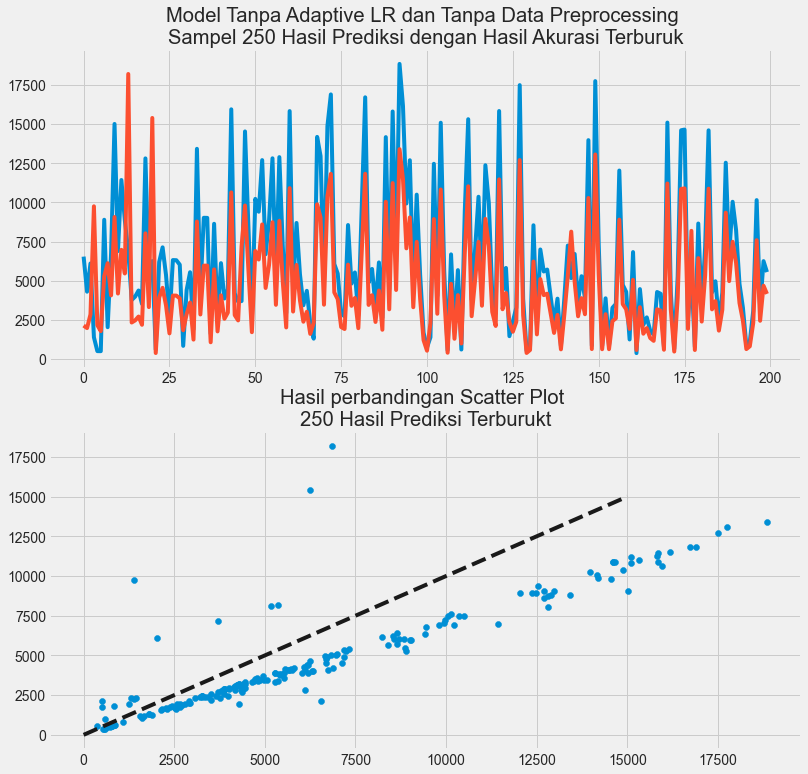

In [118]:
# plot 250 terburuk
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
ax[0].plot(worst250.prediksi)
ax[0].plot(worst250.asli)
ax[0].title.set_text('Model Tanpa Adaptive LR dan Tanpa Data Preprocessing \nSampel 250 Hasil Prediksi dengan Hasil Akurasi Terburuk')
ax[1].scatter(x = worst250.prediksi, y = worst250.asli)
ax[1].title.set_text("Hasil perbandingan Scatter Plot \n250 Hasil Prediksi Terburukt")
ax[1].plot([0, 15000], [0, 15000], ls="--", c=".1")

In [120]:
x_test

0         1         2         3    4    5    6
27461  0.115385  0.652778  0.663462  0.092684  4.0  2.0  2.0
9146   0.487179  0.555556  0.086538  0.477776  3.0  4.0  2.0
46292  0.288462  0.569444  0.759615  0.248945  4.0  2.0  5.0
7836   0.487179  0.555556  0.086538  0.476790  2.0  6.0  5.0
25778  0.038462  0.277778  0.471154  0.023664  3.0  1.0  4.0
...         ...       ...       ...       ...  ...  ...  ...
39750  0.185897  0.083333  0.759615  0.170223  4.0  5.0  1.0
19599  0.583333  0.555556  0.278846  0.565332  2.0  3.0  7.0
24622  0.038462  0.430556  0.278846  0.024847  2.0  5.0  2.0
6070   0.416667  0.513889  0.182692  0.403037  2.0  4.0  3.0
22997  0.615385  0.638889  0.278846  0.598422  2.0  2.0  1.0

[9444 rows x 7 columns]

In [ ]:
model1.history

In [ ]:
model1.save('best_model')

In [ ]:
x_test.to_csv('test_case.csv')

In [ ]:
y_test.to_csv('test_output.csv')

In [ ]:
data_y.describe()

In [ ]:
import pickle

In [ ]:
pickle.dump()

In [ ]:
import joblib

In [ ]:
joblib.dump(model1, 'best_model.pkl')

In [ ]:
model1.save('test_model', save_format = 'h5')

In [122]:
model1.evaluate(x_test_outliers)

337/337 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00


[0.0, 0.0, 0.0]